In [249]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import cvxpy as cp

from scipy.stats import spearmanr
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from scipy.optimize import minimize
from matplotlib.backends.backend_svg import FigureCanvasSVG

from prep_factor import PrepFactor
from functions.utils.system import *
from functions.utils.func import *

import warnings

warnings.filterwarnings('ignore')

In [250]:
# Params
live = True
start = '2005-01-01'
current_date = date.today().strftime('%Y-%m-%d')
window = 60
threshold = 2_000_000_000
stock = read_stock(get_large_dir(live) / 'permno_live.csv')

In [252]:
# Read in Data
price = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
fund_q = pd.read_parquet(get_parquet_dir(live) / 'data_fund_raw_q.parquet.brotli')
rf = pd.read_parquet(get_parquet_dir(live) / 'data_rf.parquet.brotli')
ret_price = create_return(price, [1])

# Resample to daily
date_index = price.drop(price.columns, axis=1)
fund_q = date_index.merge(fund_q, left_index=True, right_index=True, how='left').groupby('permno').ffill()

# Beta

In [253]:
sb_pca = PrepFactor(live=live, factor_name='factor_sb_pca', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=current_date, save=False).prep()
sb_sector = PrepFactor(live=live, factor_name='factor_sb_sector', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=current_date, save=False).prep() 

Creating factor_sb_pca ------------------------------------- | ✔
Shape: (3104852, 24)
Creating factor_sb_sector ---------------------------------- | ✔
Shape: (3104852, 32)


# Standard Rank

In [254]:
factor = pd.merge(ret_price, sb_pca, left_index=True, right_index=True, how='left').merge(sb_sector, left_index=True, right_index=True, how='left')

In [255]:
# Add market_cap
market = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])

# # Resample to monthly
# market = month(market)

factor = factor.merge(market, left_index=True, right_index=True, how='left')

In [261]:
df = factor.copy(deep=True)

In [262]:
# Filtering by Market Capitalization
df = df[df['market_cap'] >= threshold]

In [307]:
# Ranking Securities within Each Factor
factors = [
    "PCA_Return_1_ret_pca_01_126",
    "PCA_Return_2_ret_pca_01_126",
    "PCA_Return_3_ret_pca_01_126",
    "PCA_Return_4_ret_pca_01_126",
    "PCA_Return_5_ret_pca_01_126",
    "XLB_RET_01_sector_01_126",
    "XLE_RET_01_sector_01_126",
    "XLF_RET_01_sector_01_126",
    "XLI_RET_01_sector_01_126",
    "XLK_RET_01_sector_01_126",
    "XLP_RET_01_sector_01_126",
    "XLU_RET_01_sector_01_126",
    "XLV_RET_01_sector_01_126",
    "XLY_RET_01_sector_01_126",
]

for factor_name in factors:
    print(factor_name)
    df[f'{factor_name}_Rank'] = df.groupby('date')[factor_name].rank(ascending=False)

PCA_Return_1_ret_pca_01_126
PCA_Return_2_ret_pca_01_126
PCA_Return_3_ret_pca_01_126
PCA_Return_4_ret_pca_01_126
PCA_Return_5_ret_pca_01_126
XLB_RET_01_sector_01_126
XLE_RET_01_sector_01_126
XLF_RET_01_sector_01_126
XLI_RET_01_sector_01_126
XLK_RET_01_sector_01_126
XLP_RET_01_sector_01_126
XLU_RET_01_sector_01_126
XLV_RET_01_sector_01_126
XLY_RET_01_sector_01_126


In [308]:
# Calculating Average Rank
df['avg_rank'] = df[[f'{f}_Rank' for f in factors]].mean(axis=1)

In [309]:
# Calculating rank weights
df['rank_weight'] = (1 / len(factors)) * df['avg_rank']

In [310]:
df['rank_weight'] = df['rank_weight'].groupby('permno').shift(1)

In [311]:
# Calculating inverse volatility (using past 36 months)
df['vol'] = df.groupby('permno')['RET_01'].transform(lambda x: x.rolling(21).std())
df['inv_vol_weight'] = 1 / df['vol']

In [312]:
# Find adjusted weight that accounts for rank and inverse volatility
df['adj_weight'] = df['rank_weight'] * df['inv_vol_weight']

In [313]:
# Function to select top and bottom stocks
def select_top_bottom_stocks(group):
    top_stocks = group.nlargest(25, 'adj_weight')
    bottom_stocks = group.nsmallest(25, 'adj_weight')
    top_stocks['final_weight'] = top_stocks['adj_weight'] * 1
    bottom_stocks['final_weight'] = bottom_stocks['adj_weight'] * -1
    return pd.concat([top_stocks, bottom_stocks])

In [314]:
# Selecting Top and Bottom Stocks
top_bottom_stocks = df.groupby('date').apply(select_top_bottom_stocks).reset_index(level=0, drop=True)

In [315]:
# Normalizing Weights
top_bottom_stocks['final_weight'] /= top_bottom_stocks.groupby('date')['final_weight'].transform(lambda x: x.abs().sum())

In [316]:
top_bottom_stocks['total_ret'] = top_bottom_stocks['RET_01'] * top_bottom_stocks['final_weight']

In [317]:
total_ret = top_bottom_stocks.groupby('date').total_ret.sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2008-01-03   2008-01-03
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          204.02%      190.12%
CAGR﹪                     4.96%        4.74%

Sharpe                     0.45         1.03
Prob. Sharpe Ratio         96.16%       100.0%
Smart Sharpe               0.43         1.0
Sortino                    0.62         1.43
Smart Sortino              0.61         1.4
Sortino/√2                 0.44         1.01
Smart Sortino/√2           0.43         0.99
Omega                      1.2          1.2

Max Drawdown               -52.98%      -39.05%
Longest DD Days            1714         1917
Volatility (ann.)          20.47%       6.78%
R^2                        0.16         0.16
Information Ratio          -0.01        -0.01
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-01-10,2009-05-21,2013-04-09,1917,-39.047736,-38.327133
2,2020-02-19,2020-03-25,2020-09-01,196,-10.915004,-9.138113
3,2020-10-14,2021-02-26,2021-05-05,204,-9.179365,-8.952285
4,2022-05-25,2023-02-02,2023-11-10,535,-7.392909,-7.089910
5,2018-12-14,2019-01-07,2019-03-12,89,-4.428361,-4.187049


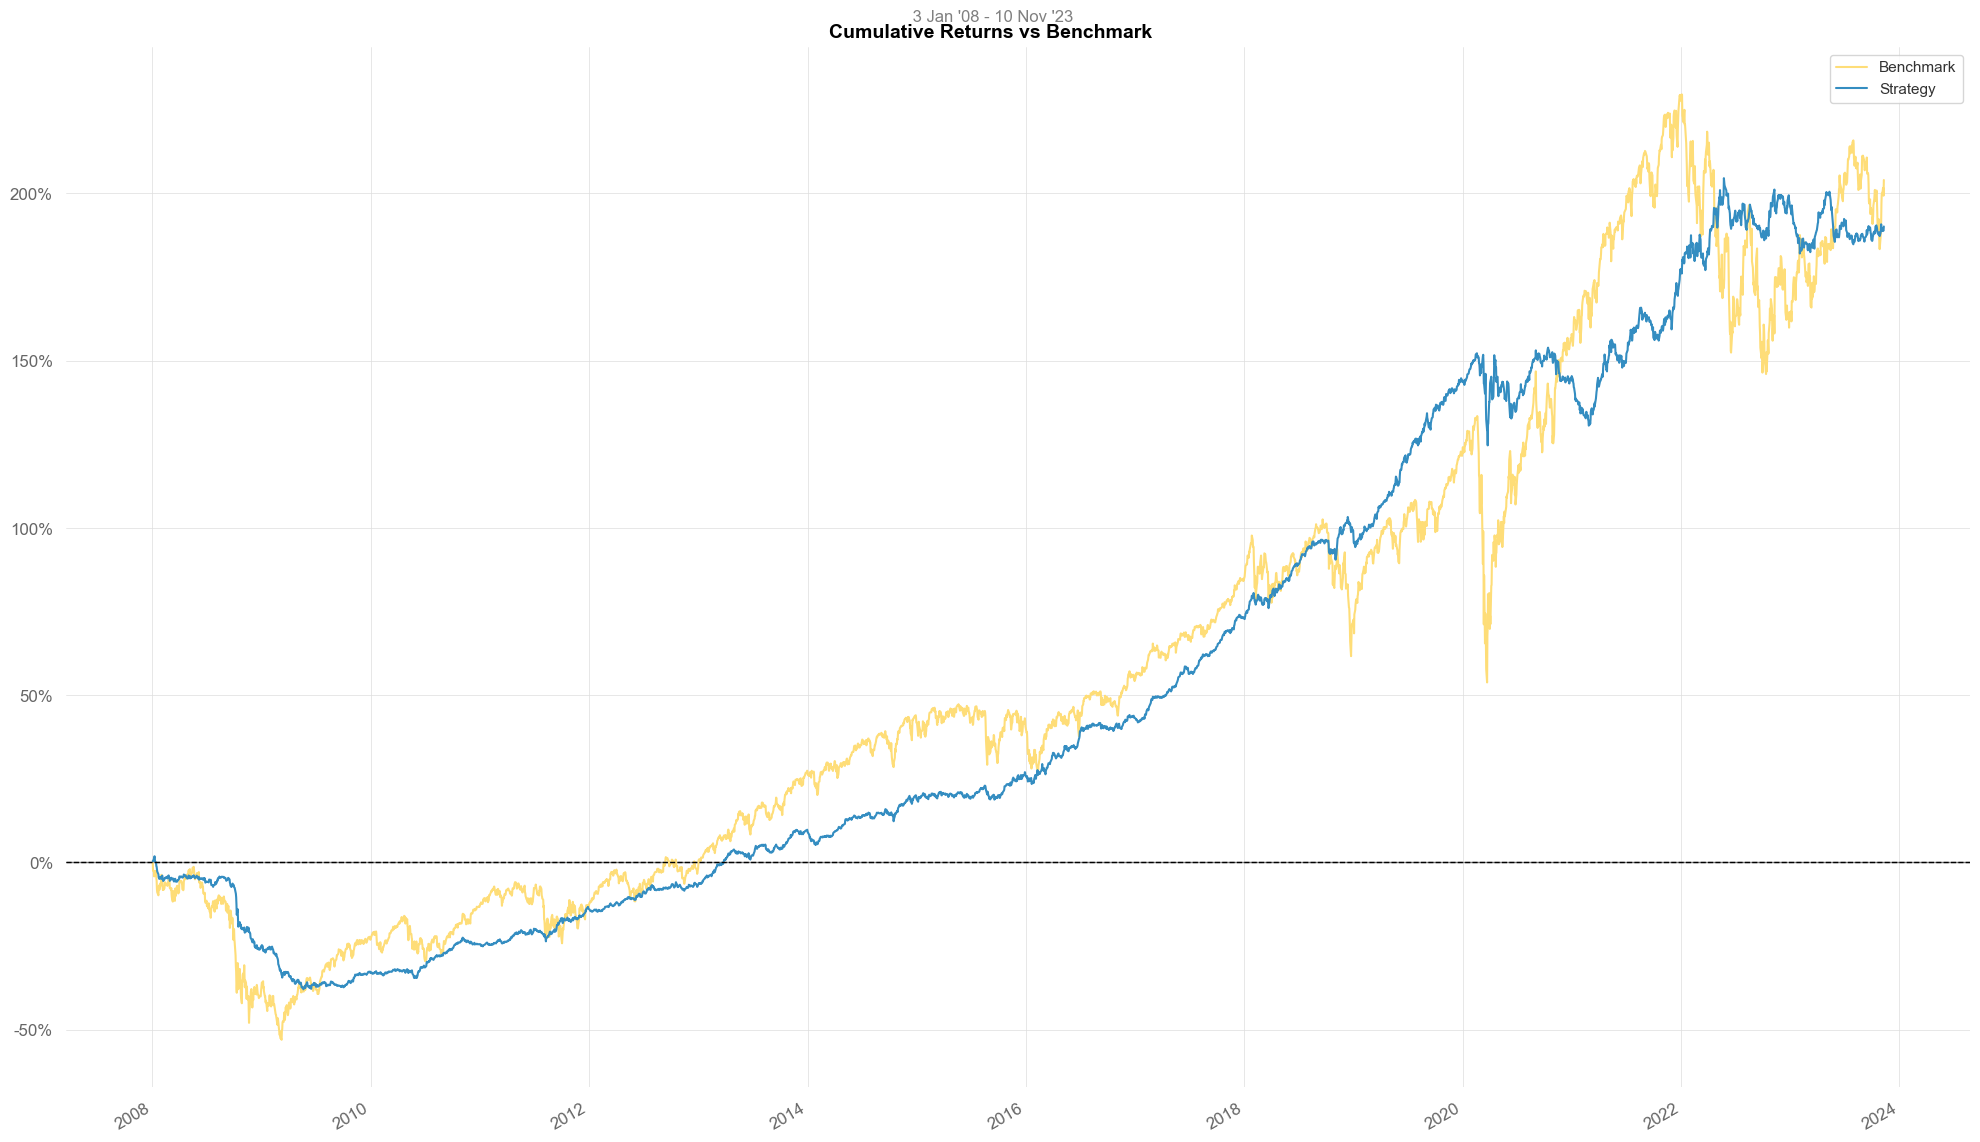

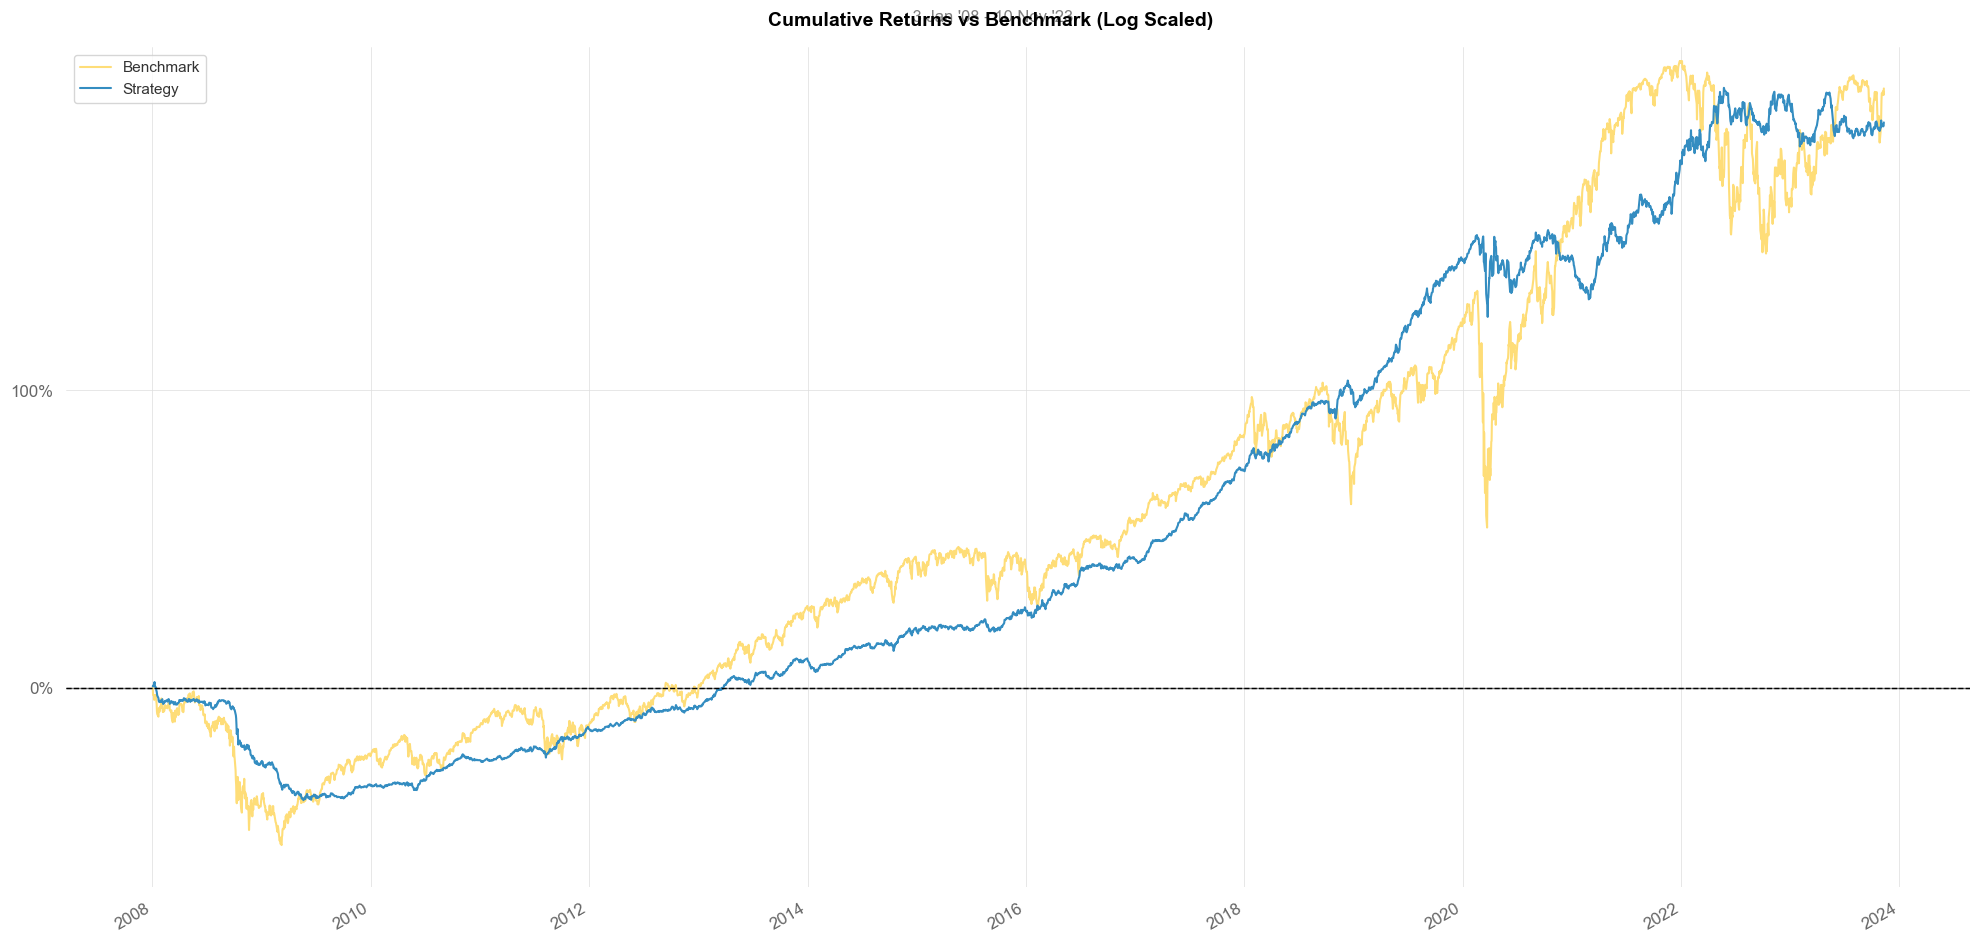

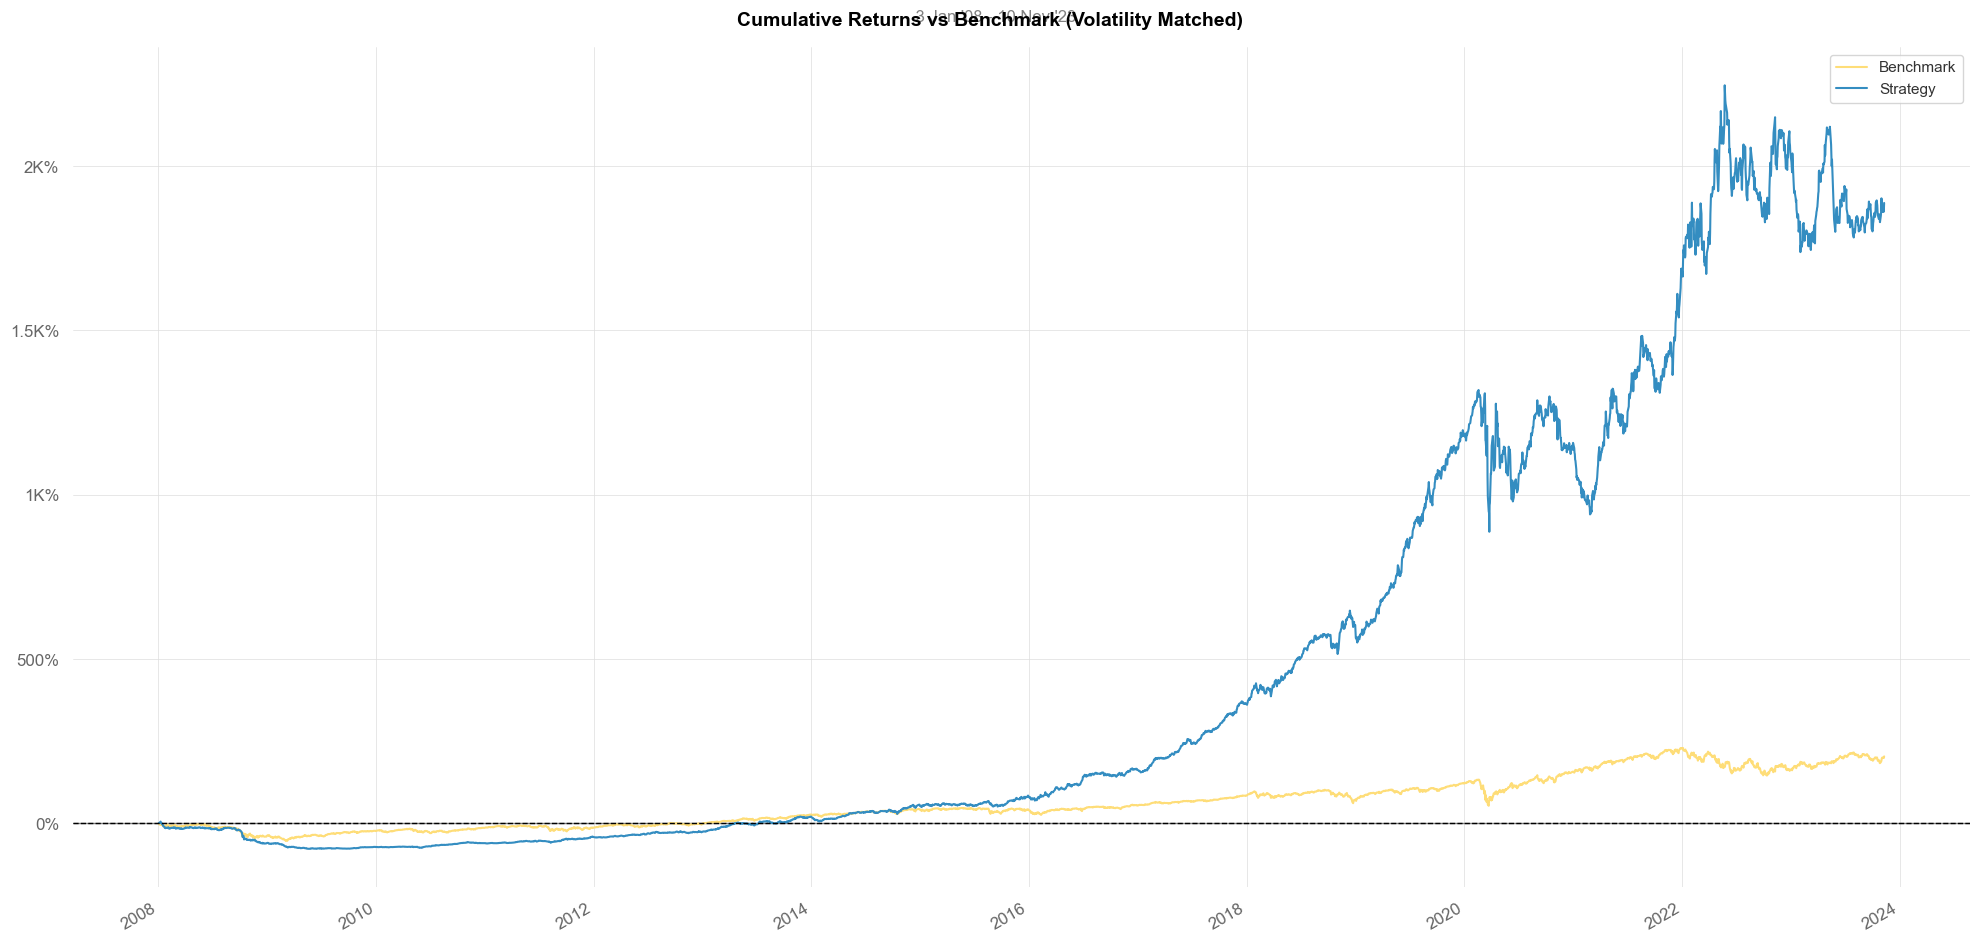

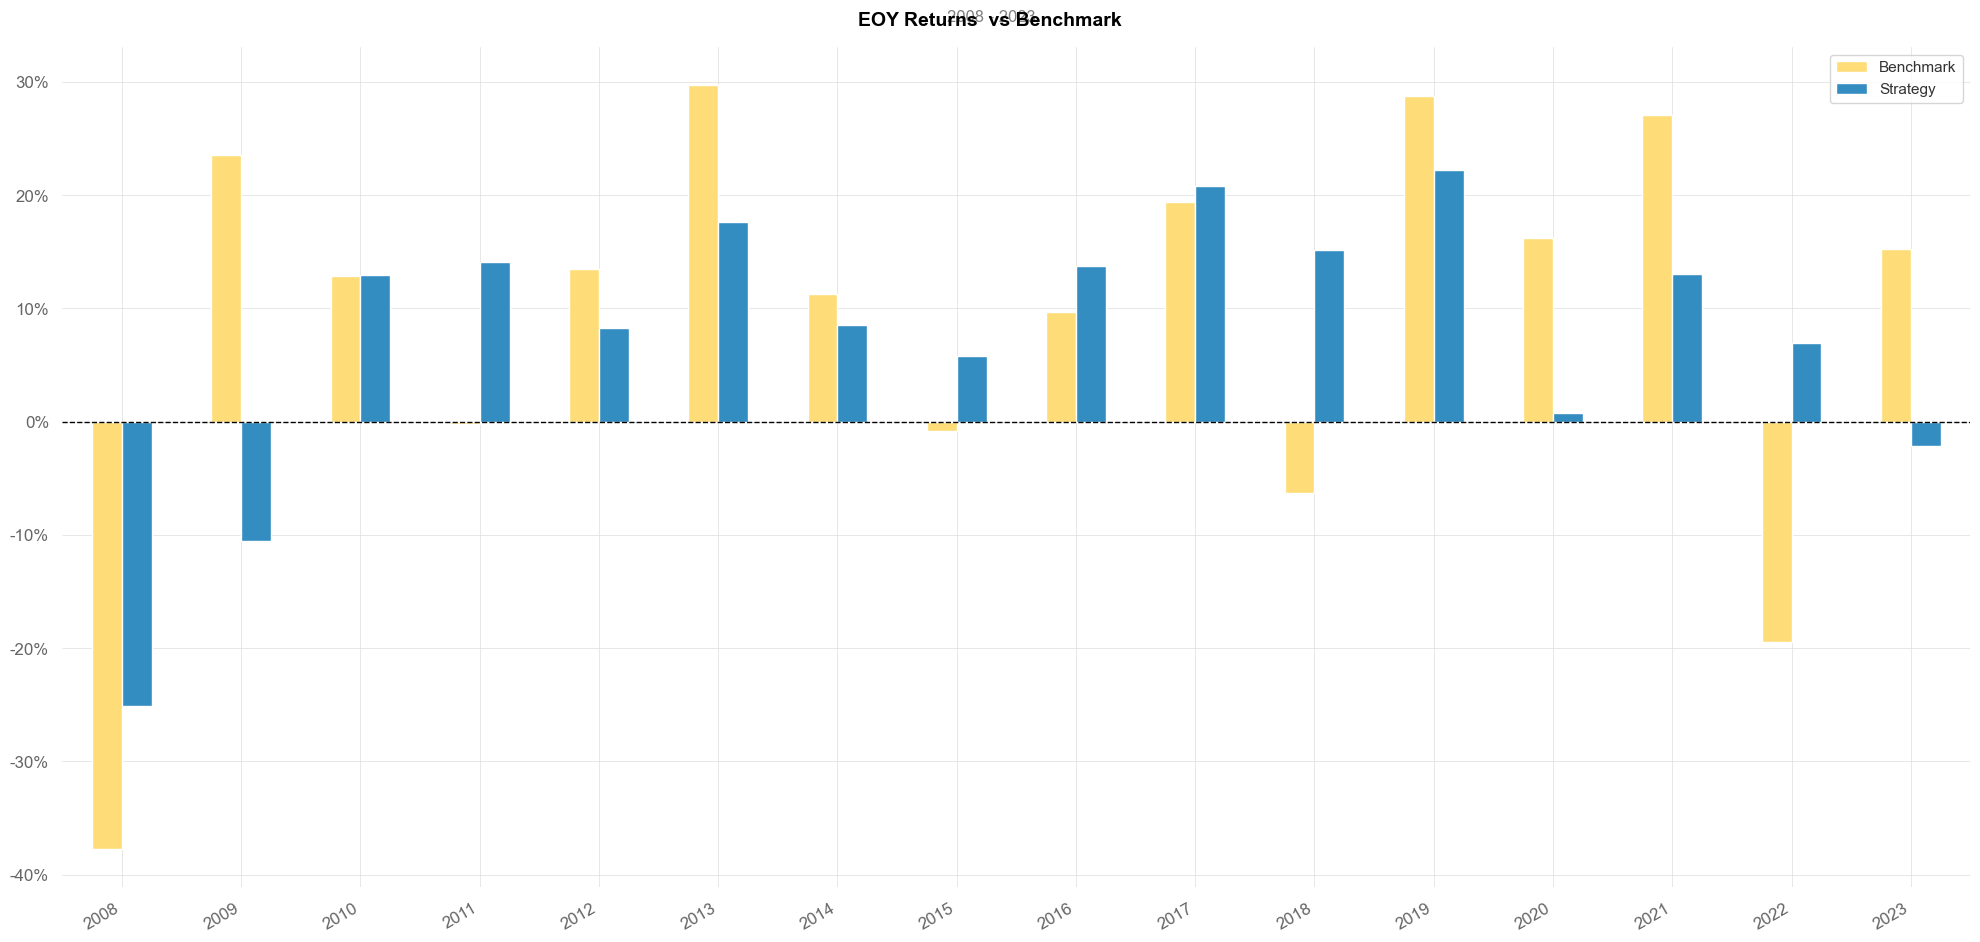

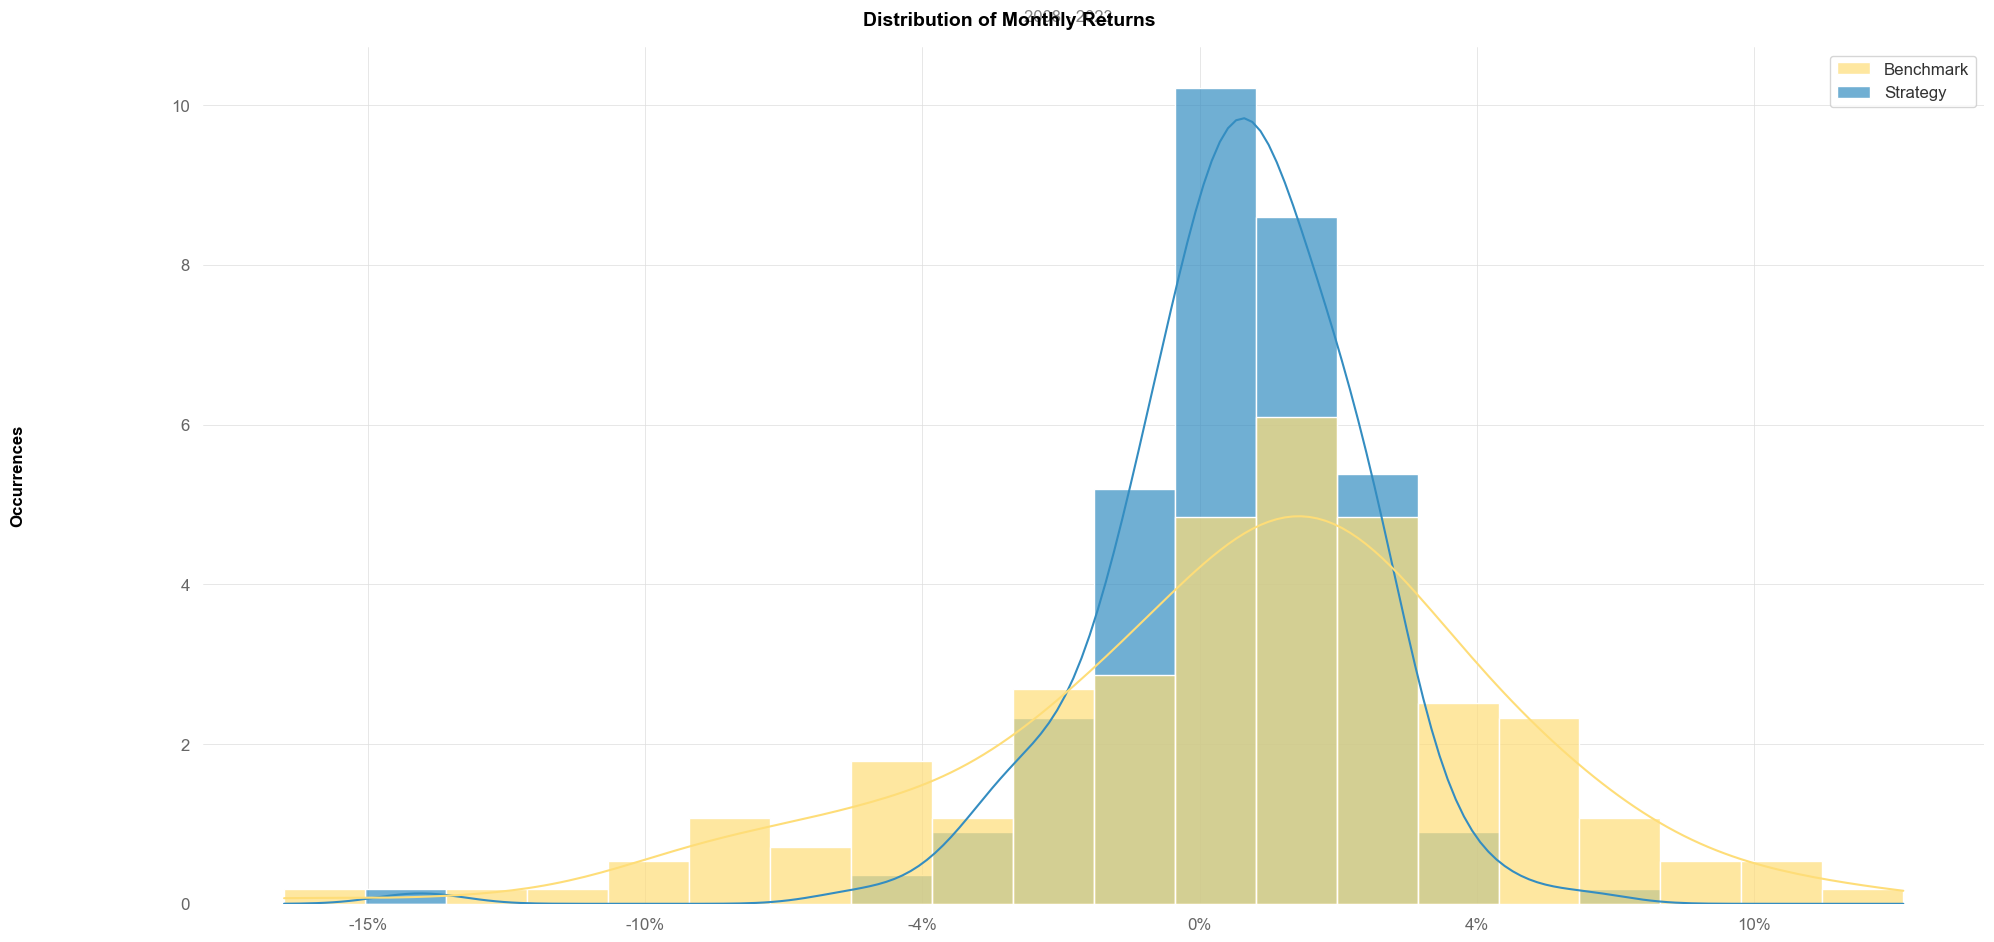

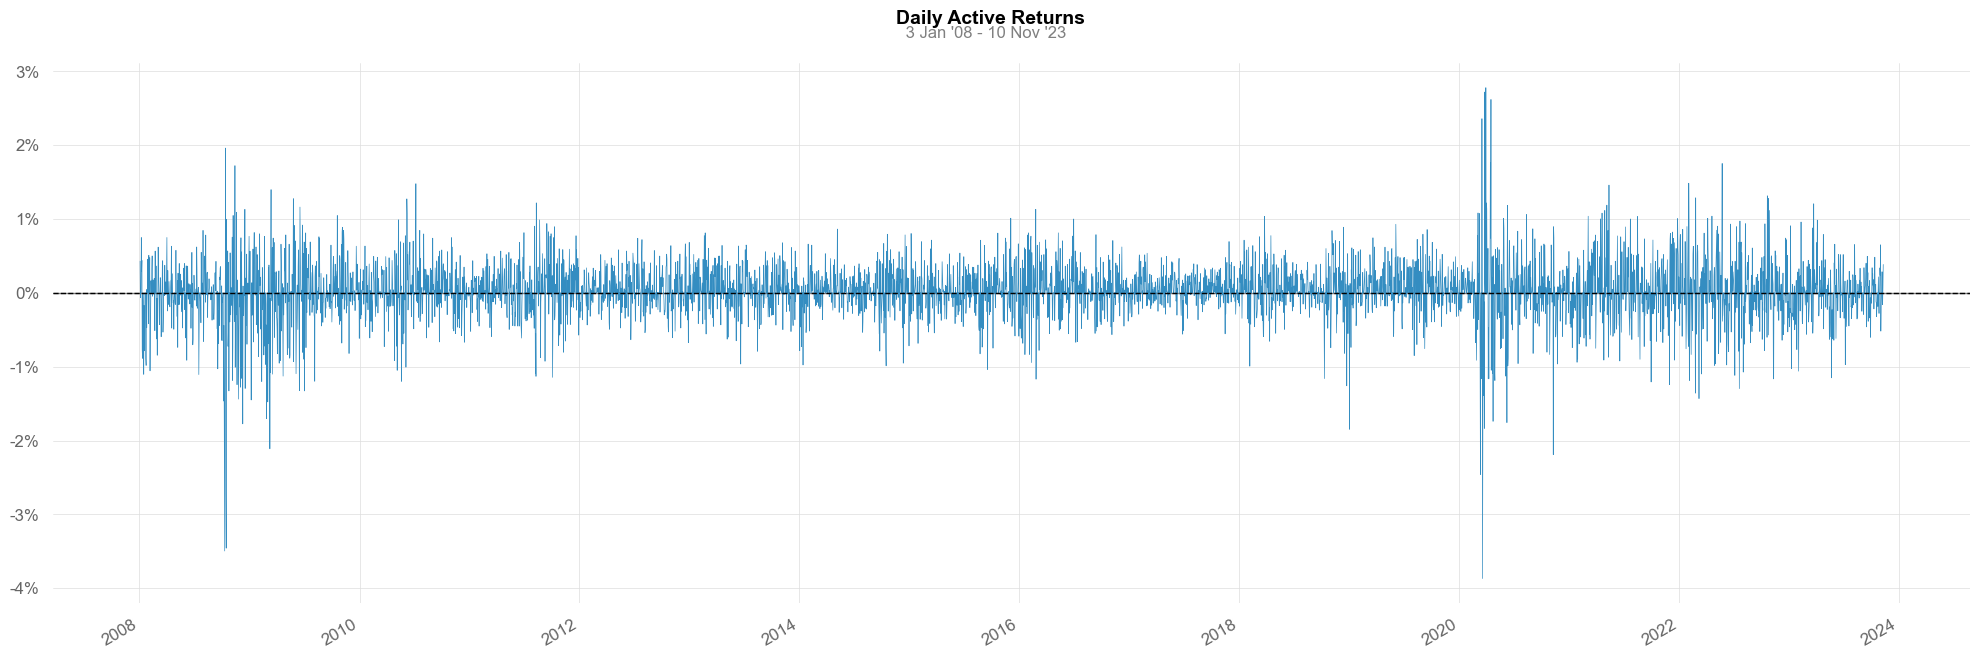

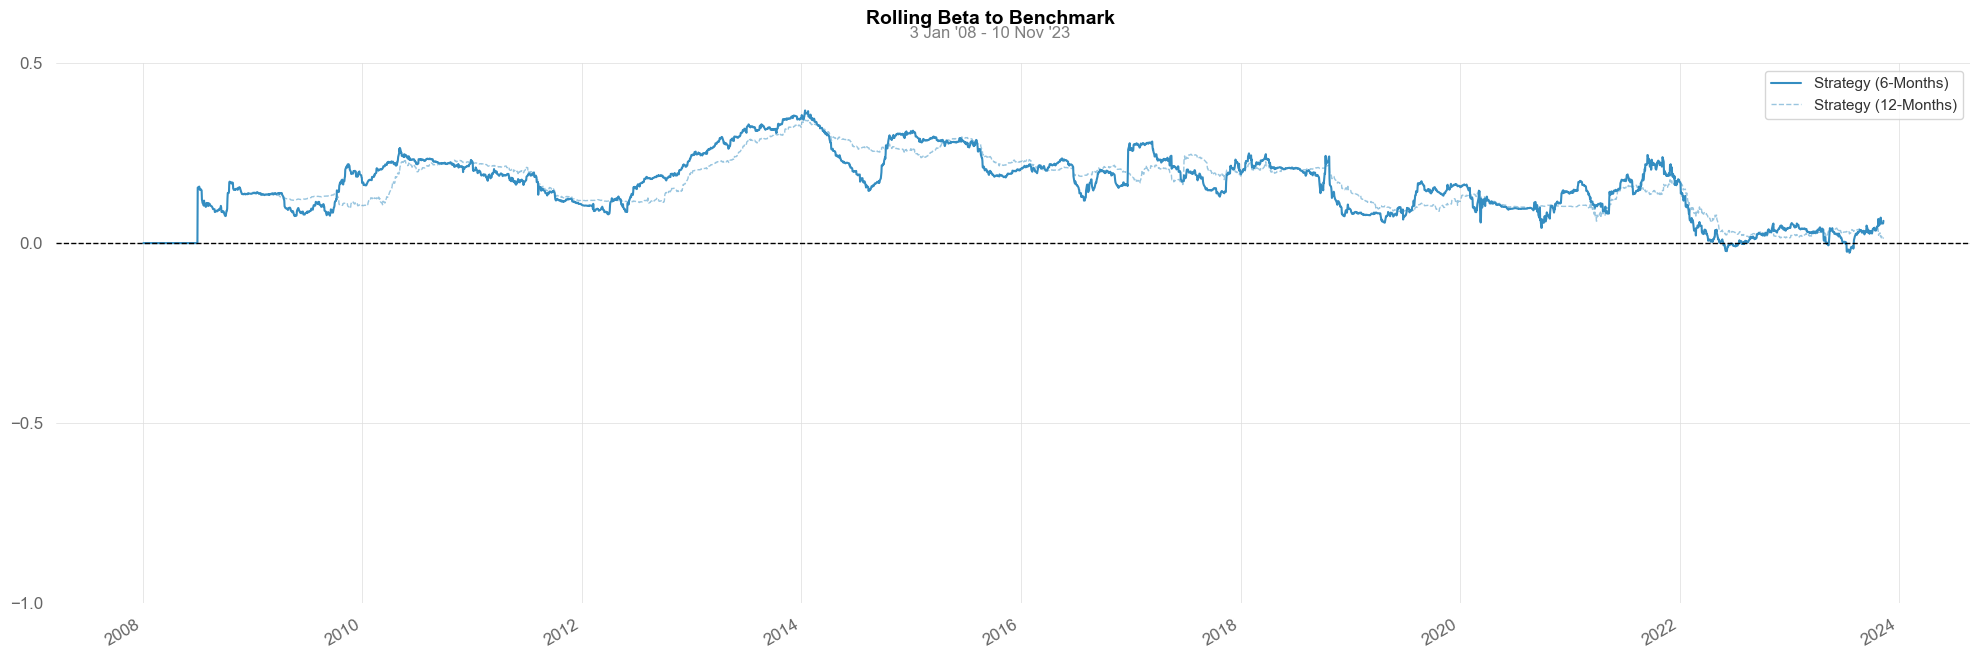

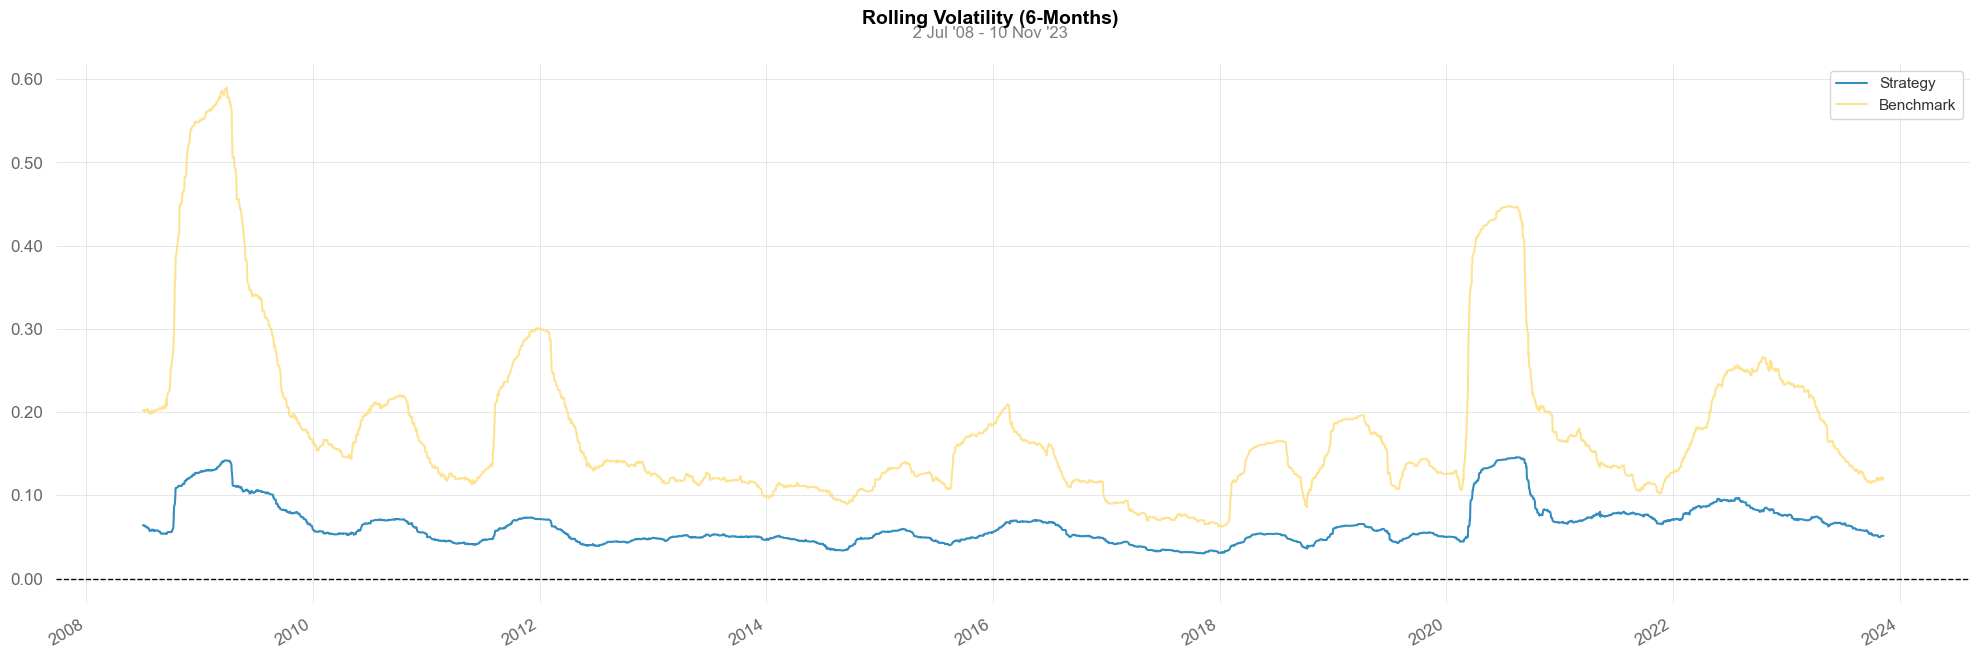

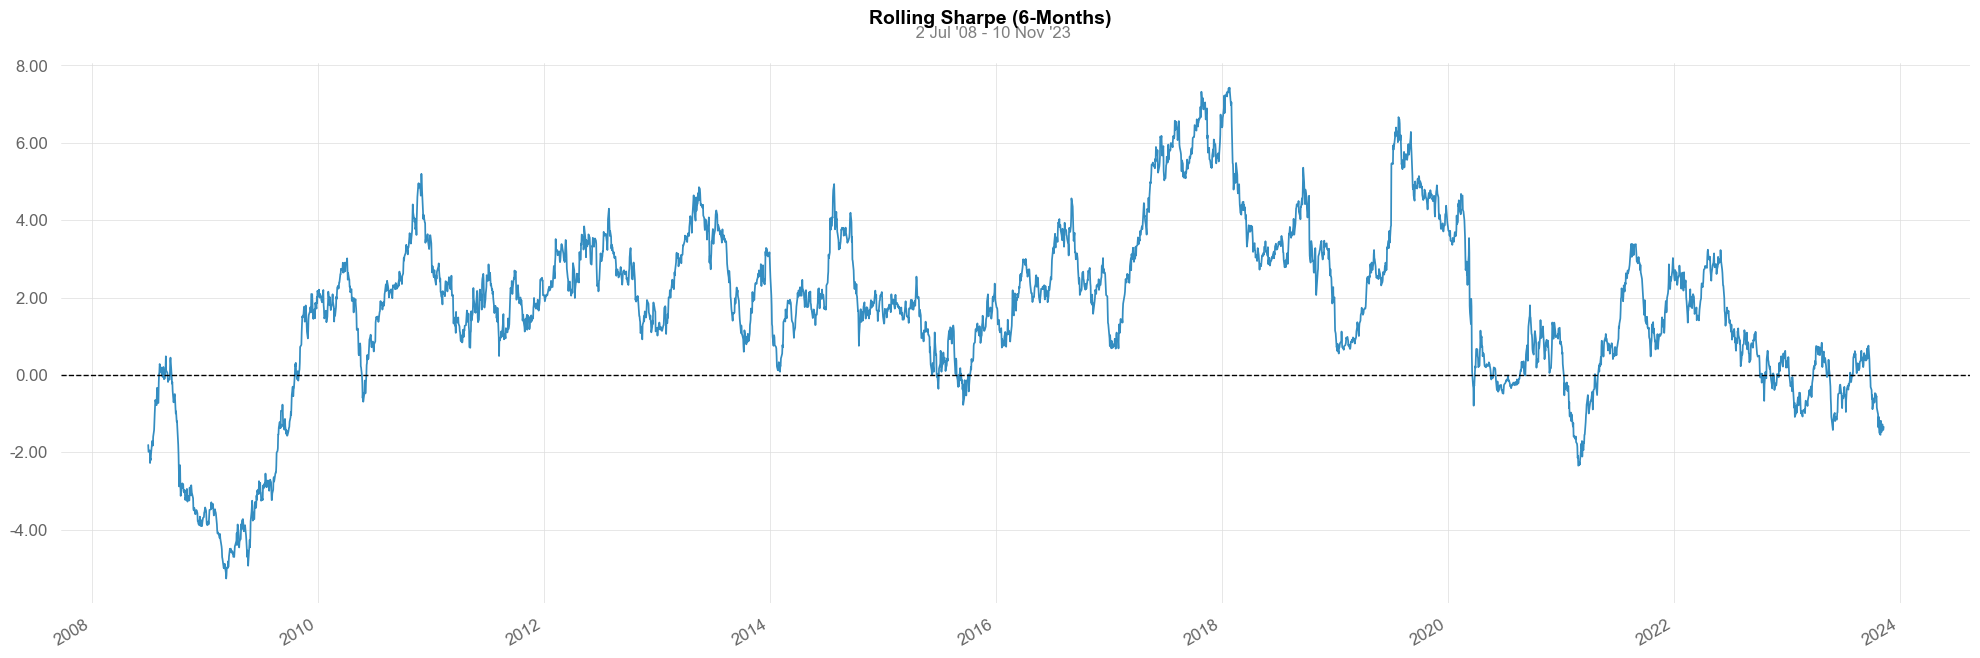

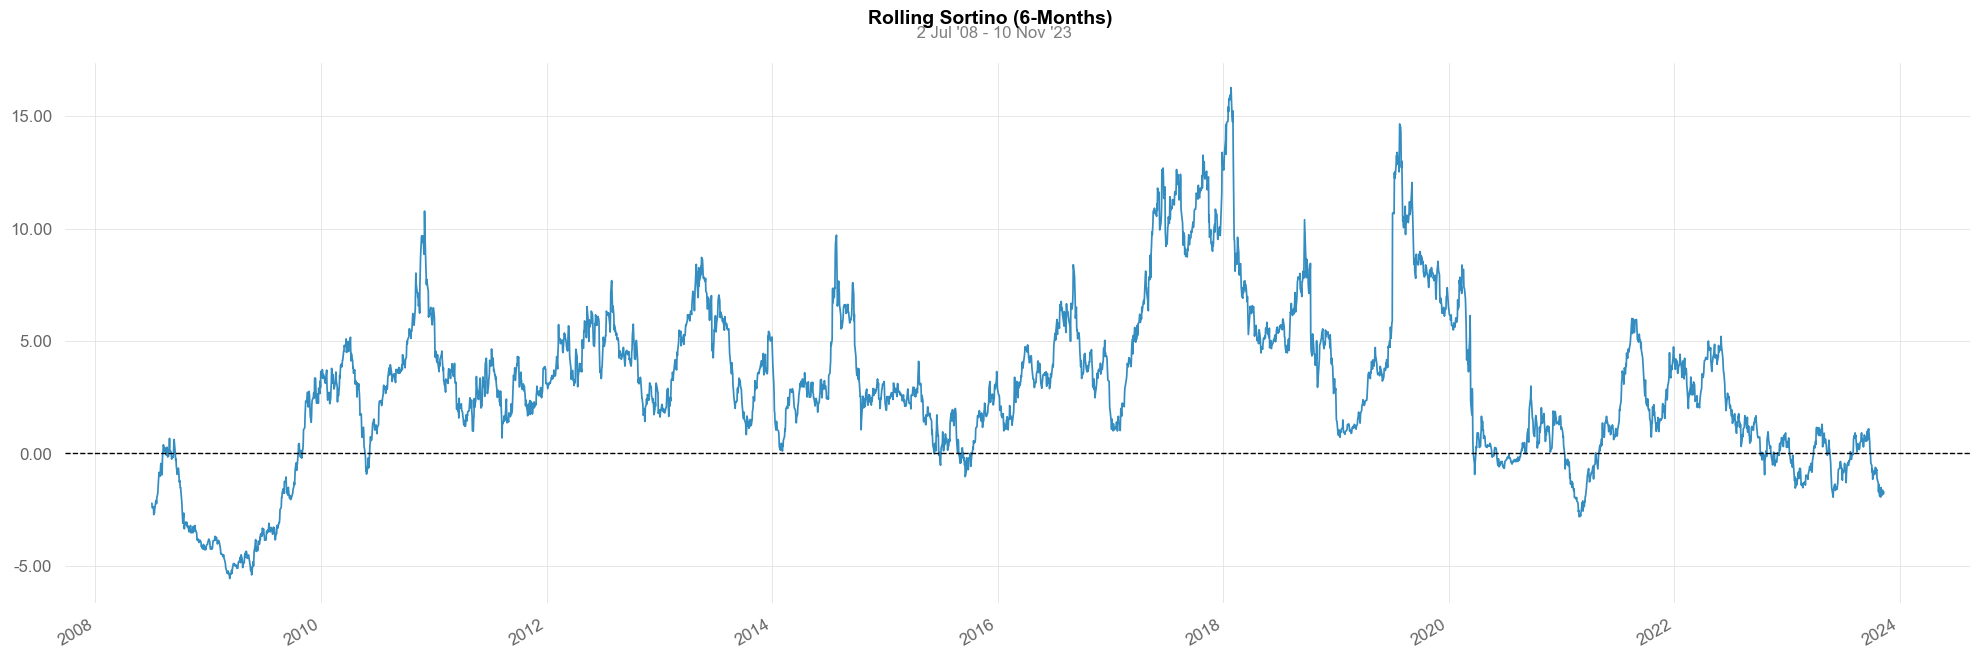

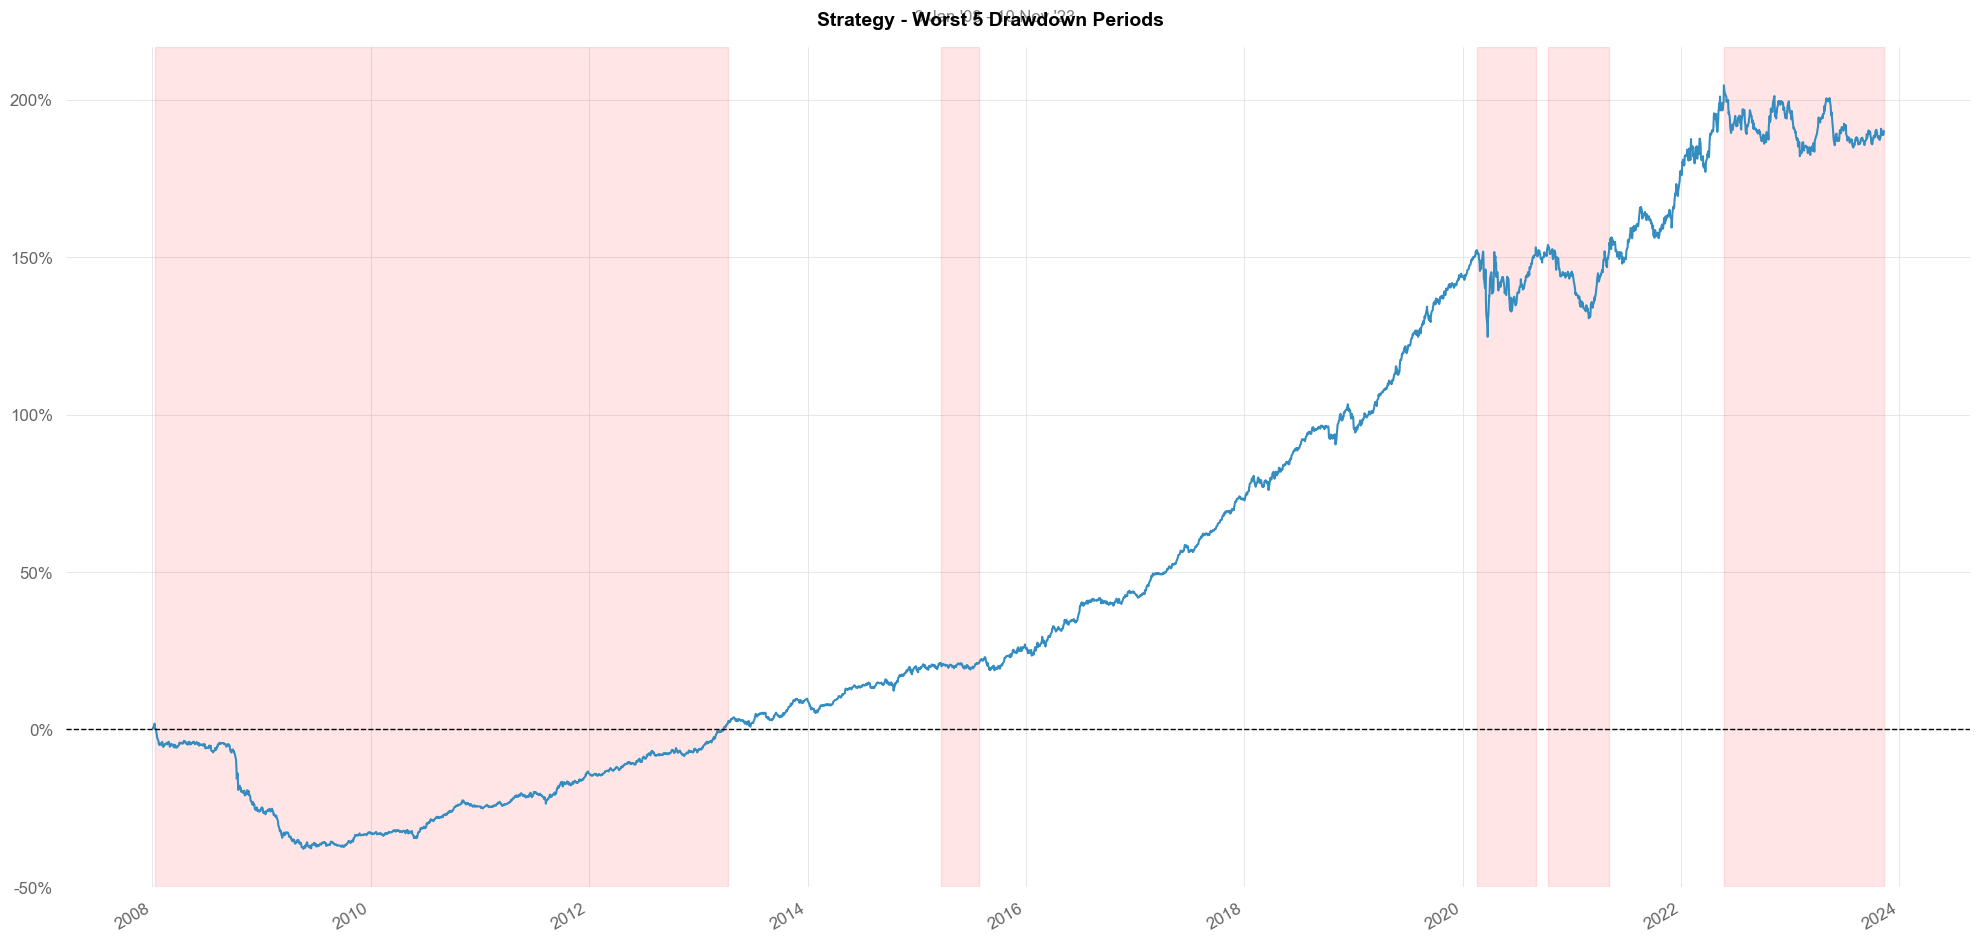

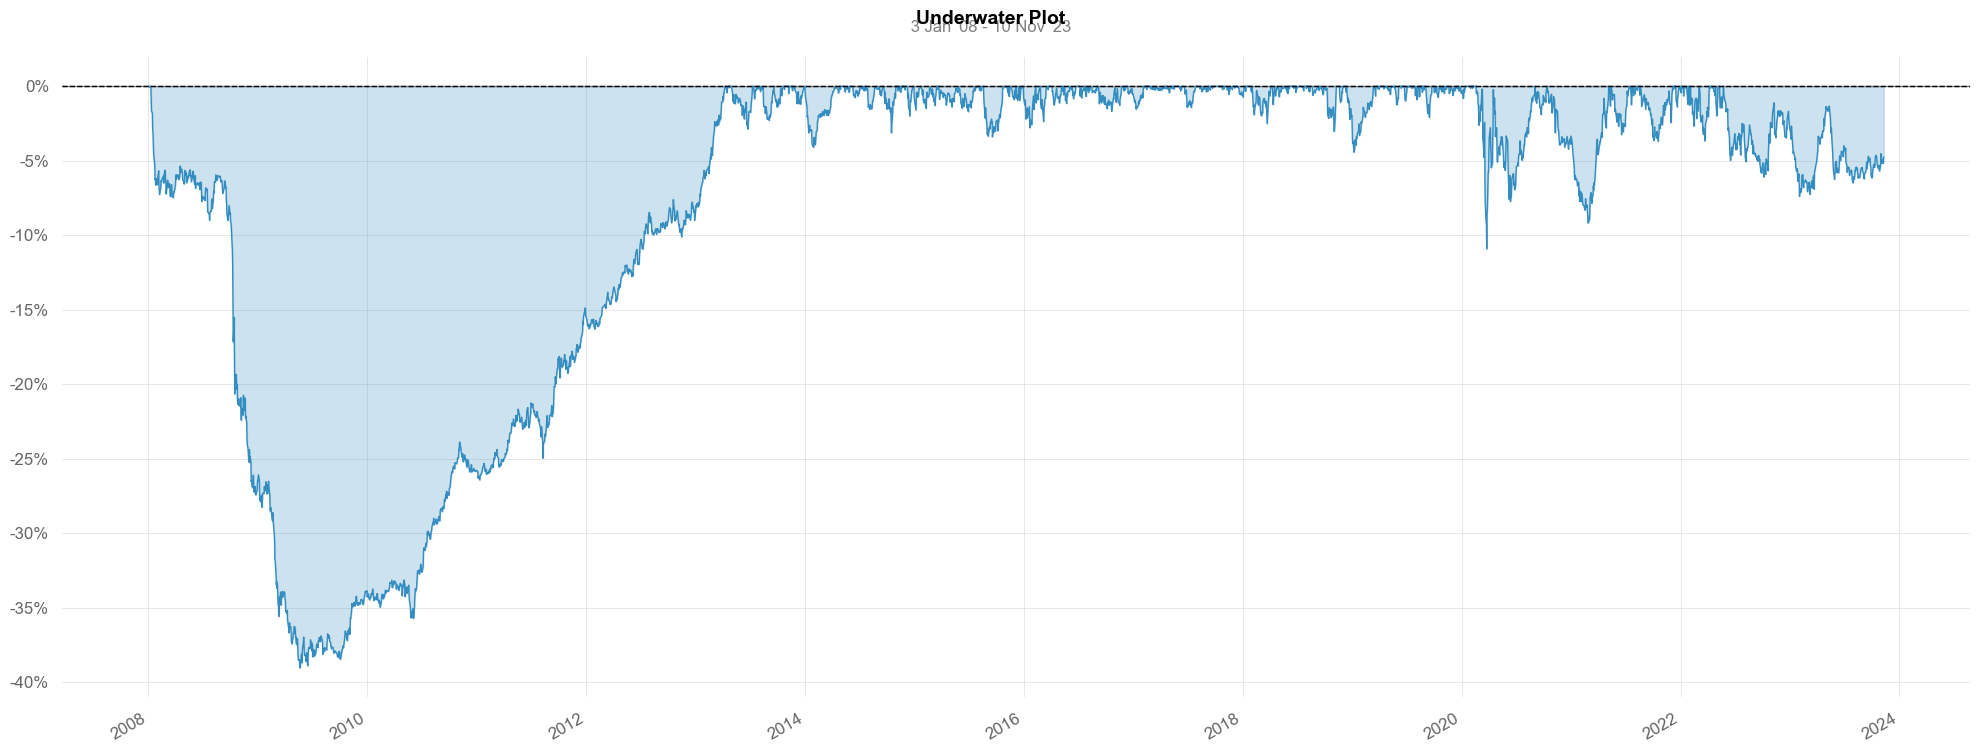

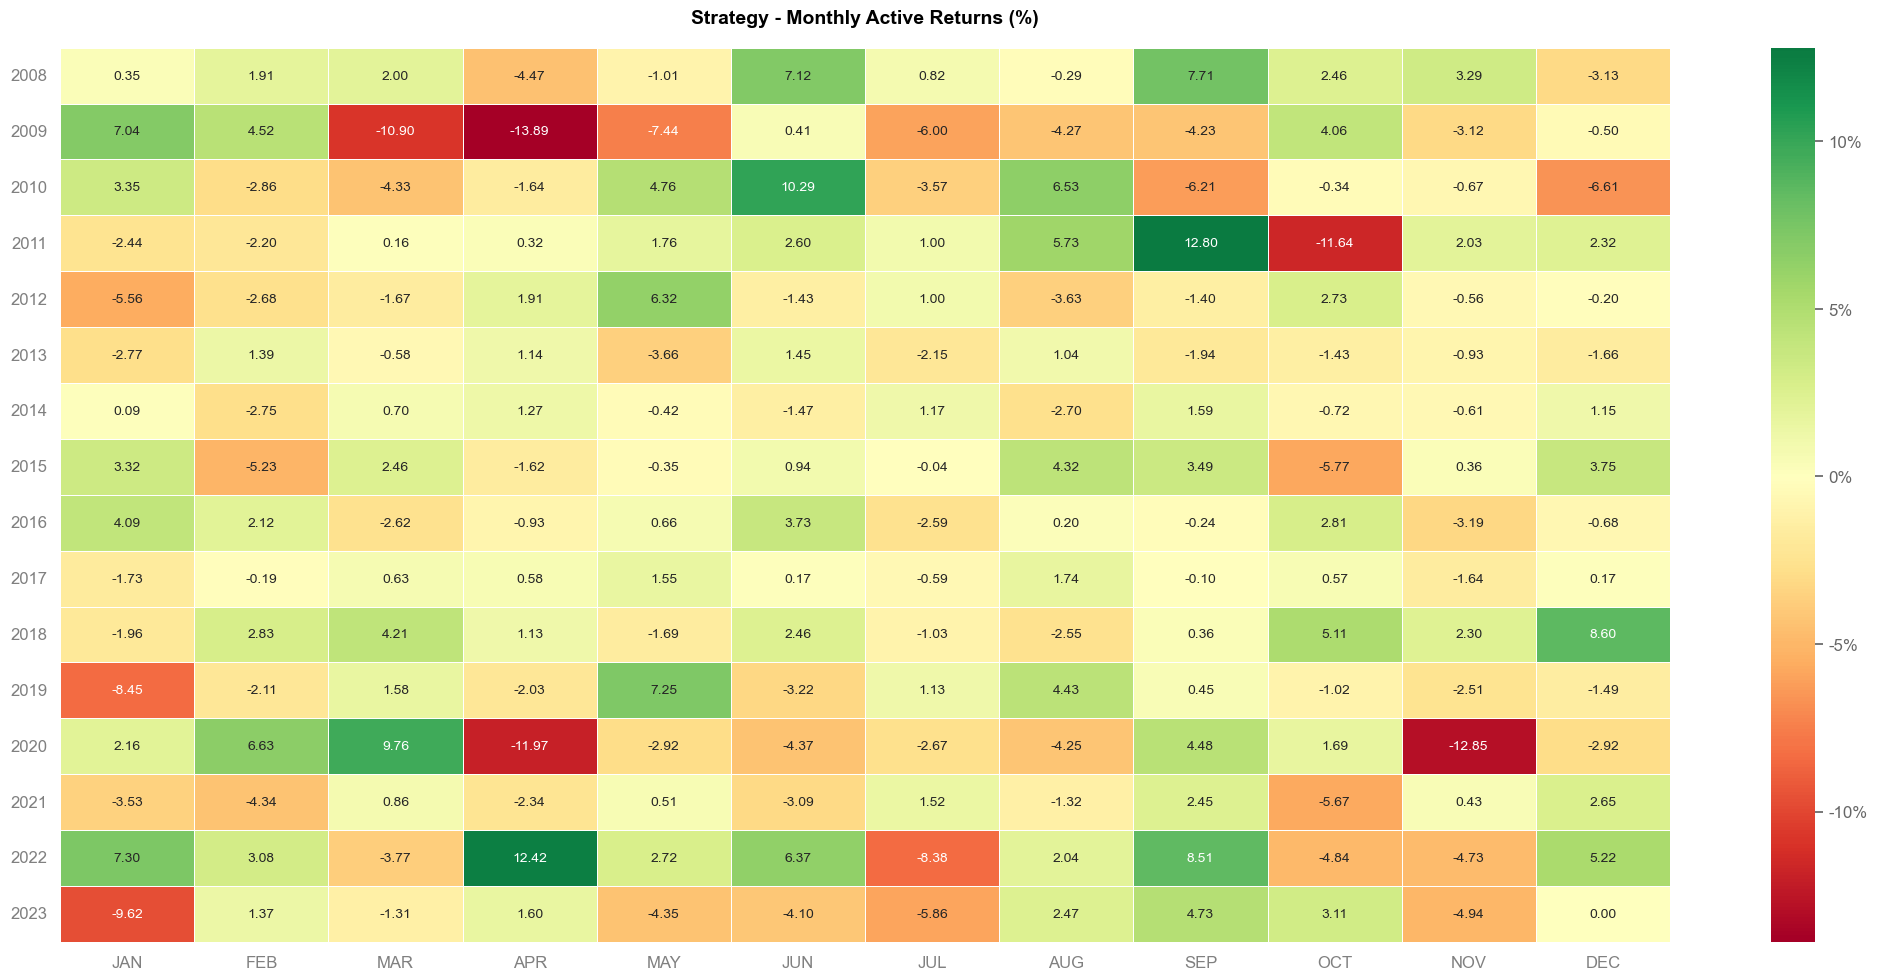

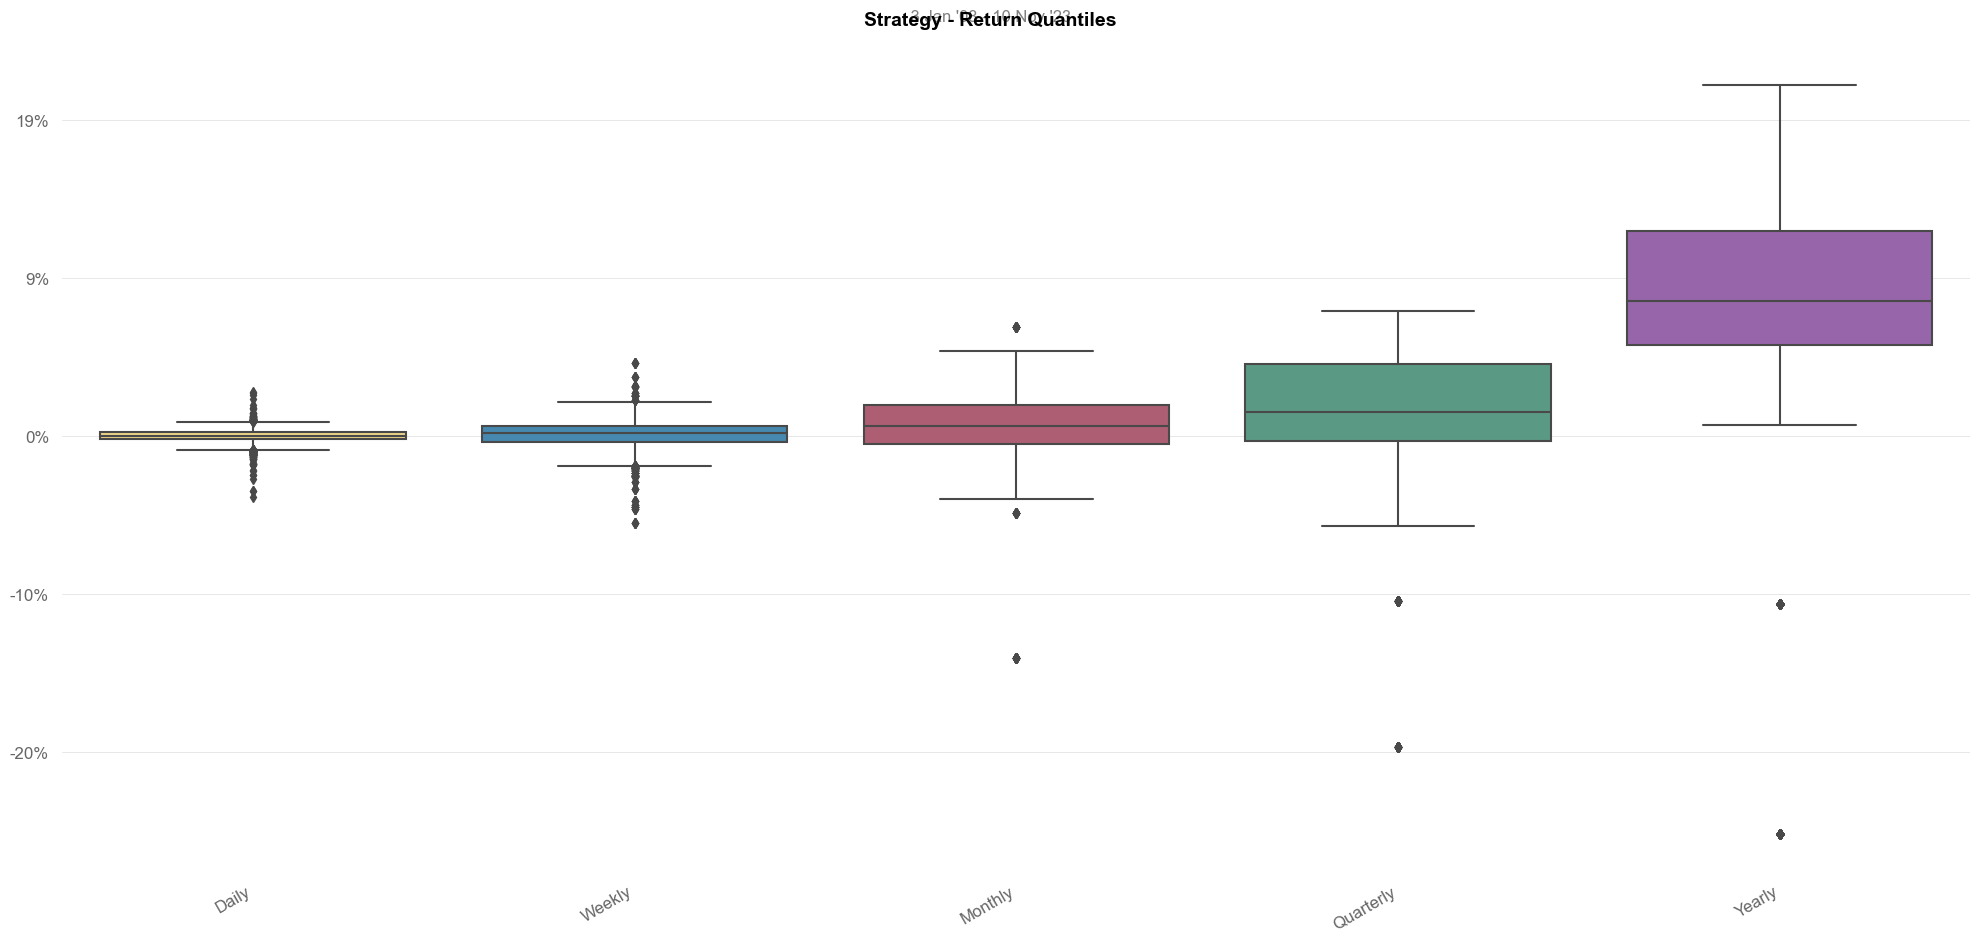

In [318]:
qs.reports.full(total_ret, 'SPY', figsize=(20, 10))

# Beta Neutral

In [427]:
df = factor.copy(deep=True)

In [428]:
# Filtering by Market Capitalization
df = df[df['market_cap'] >= threshold]

In [429]:
# Ranking Securities within Each Factor
factors = [
    "PCA_Return_1_ret_pca_01_126",
    "PCA_Return_2_ret_pca_01_126",
    "PCA_Return_3_ret_pca_01_126",
    "PCA_Return_4_ret_pca_01_126",
    "PCA_Return_5_ret_pca_01_126",
    "XLB_RET_01_sector_01_126",
    "XLE_RET_01_sector_01_126",
    "XLF_RET_01_sector_01_126",
    "XLI_RET_01_sector_01_126",
    "XLK_RET_01_sector_01_126",
    "XLP_RET_01_sector_01_126",
    "XLU_RET_01_sector_01_126",
    "XLV_RET_01_sector_01_126",
    "XLY_RET_01_sector_01_126",
]

df = df[['RET_01'] + factors]

In [430]:
def calc_avg_beta(df, beta_columns):
    df['avg_beta'] = df[beta_columns].mean(axis=1)
    df['avg_beta'] = df['avg_beta'].groupby('permno').shift(1)
    return df

def rank_beta(df):
    df['beta_rank'] = df.groupby('date')['avg_beta'].rank()
    return df

def calc_long_short(df):
    # Find the top 25 and bottom 25 for each date using nlargest and nsmallest
    top_25 = df.groupby('date').apply(lambda x: x.nsmallest(25, 'beta_rank')).reset_index(level=0, drop=True)
    bottom_25 = df.groupby('date').apply(lambda x: x.nlargest(25, 'beta_rank')).reset_index(level=0, drop=True)

    # Assign positions
    top_25['position'] = 'long'
    bottom_25['position'] = 'short'

    # Concatenate the results
    long_short_df = pd.concat([top_25, bottom_25])

    return long_short_df

def calc_beta_neutral(df):
    # Assign initial weights inversely proportional to beta for long positions, and directly proportional for short positions
    df['initial_weight'] = df.apply(lambda x: (1 / x['avg_beta'] if x['position'] == 'long' else -x['avg_beta']), axis=1)

    # Calculate weighted beta for long and short positions
    df['weighted_beta'] = df['avg_beta'] * df['initial_weight']
    total_long_beta = df[df['position'] == 'long']['weighted_beta'].sum()
    total_short_beta = df[df['position'] == 'short']['weighted_beta'].sum()

    # Adjust weights to achieve beta neutrality
    if total_short_beta != 0:
        adjustment_factor = abs(total_long_beta / total_short_beta)
        df.loc[df['position'] == 'short', 'initial_weight'] *= adjustment_factor

    # Normalize the final weights within each date
    df['final_weight'] = df.groupby('date')['initial_weight'].transform(lambda x: x / x.abs().sum())

    return df

In [431]:
df = calc_avg_beta(df, factors)

In [432]:
df = rank_beta(df)

In [433]:
df = calc_long_short(df)

In [434]:
test = df.copy(deep=True)

In [435]:
test = calc_beta_neutral(test)

In [436]:
test['total_ret'] = test['RET_01'] * test['final_weight']

In [437]:
total_ret = test.groupby('date').total_ret.sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2008-01-03   2008-01-03
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          204.02%      -95.65%
CAGR﹪                     4.96%        -12.75%

Sharpe                     0.45         -0.3
Prob. Sharpe Ratio         96.16%       11.19%
Smart Sharpe               0.44         -0.3
Sortino                    0.62         -0.39
Smart Sortino              0.62         -0.39
Sortino/√2                 0.44         -0.28
Smart Sortino/√2           0.44         -0.28
Omega                      0.93         0.93

Max Drawdown               -52.98%      -97.85%
Longest DD Days            1714         5541
Volatility (ann.)          20.47%       38.78%
R^2                        0.0          0.0
Information Ratio          -0.03        -0.03
Calmar      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-09-09,2022-03-14,2023-11-10,5541,-97.847645,-97.733239
2,2008-01-09,2008-03-17,2008-09-04,240,-48.653040,-48.404492
3,2008-01-04,2008-01-04,2008-01-07,4,-0.775111,-0.591941


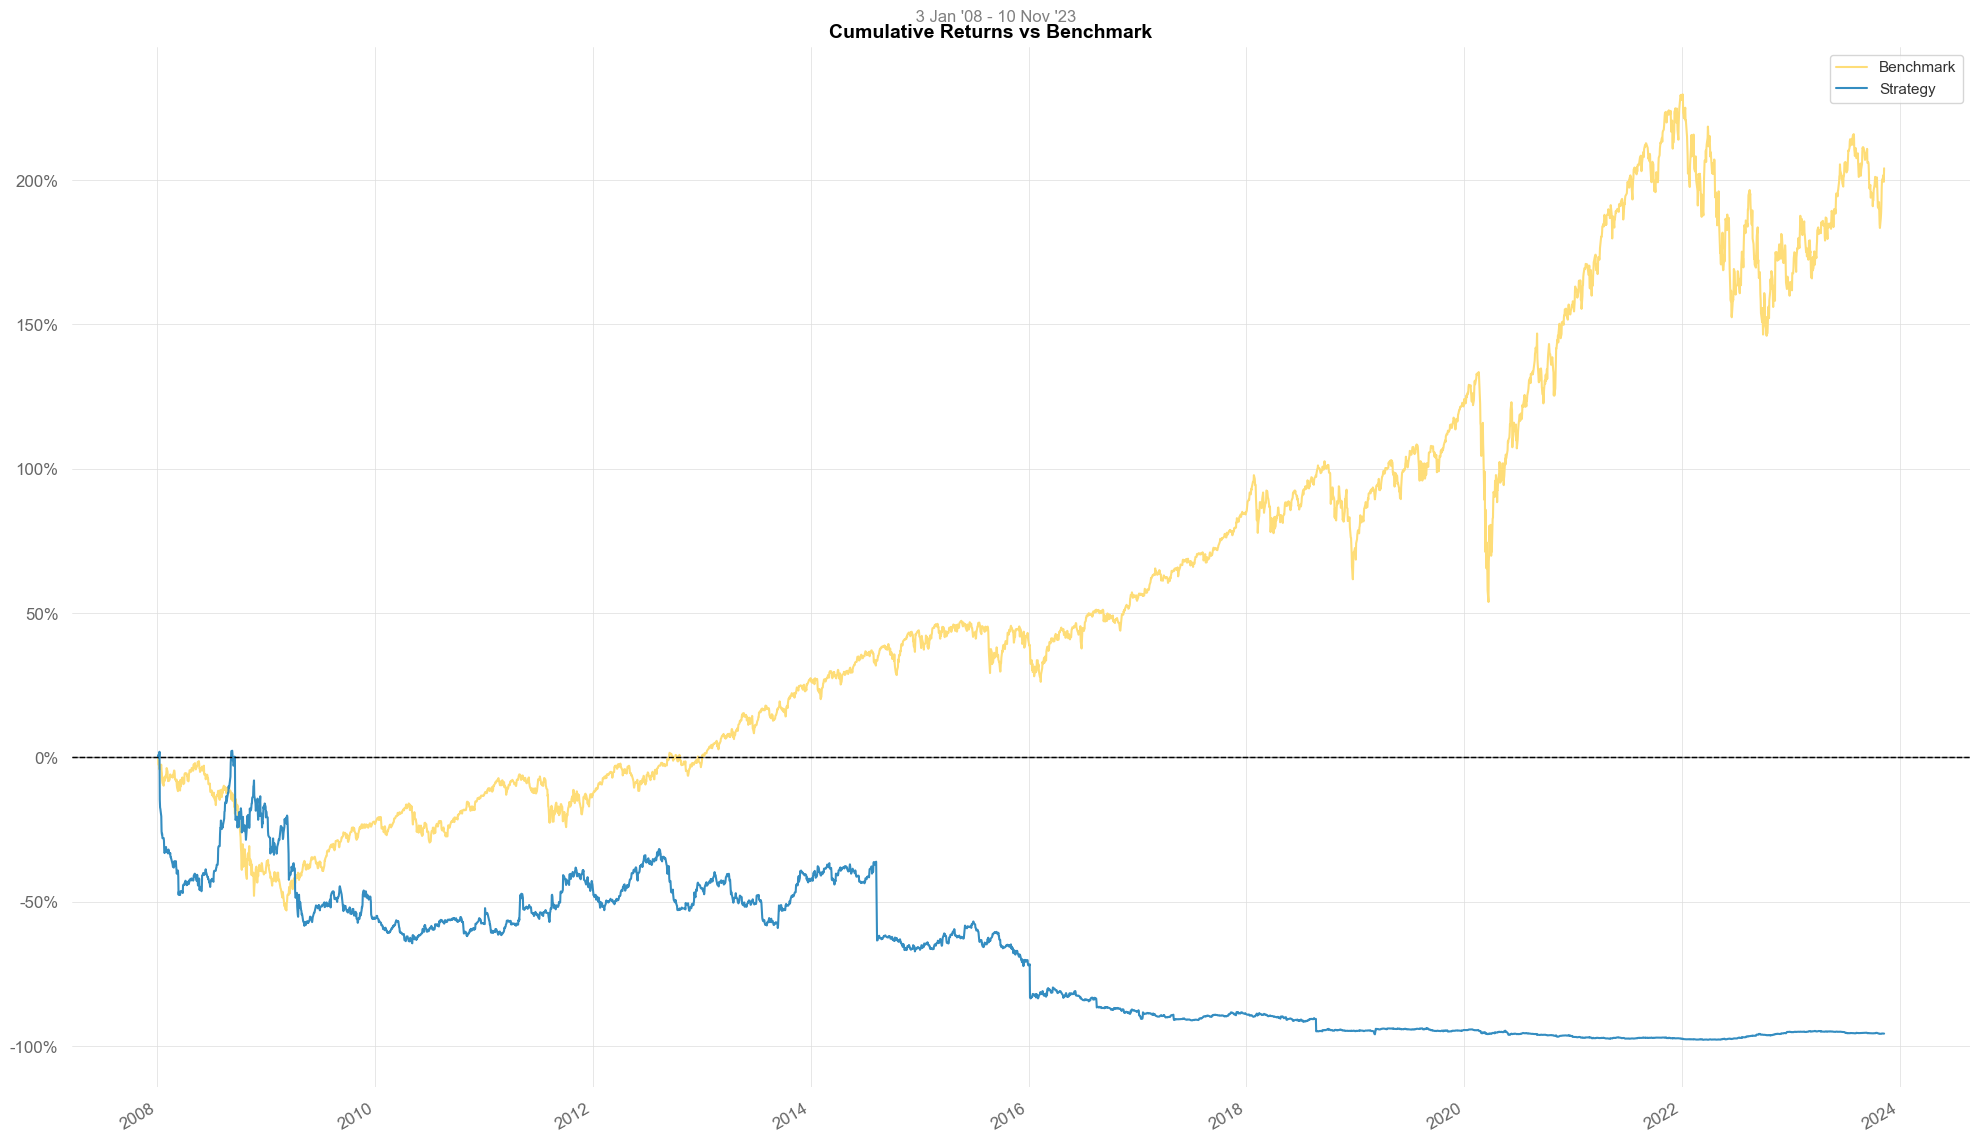

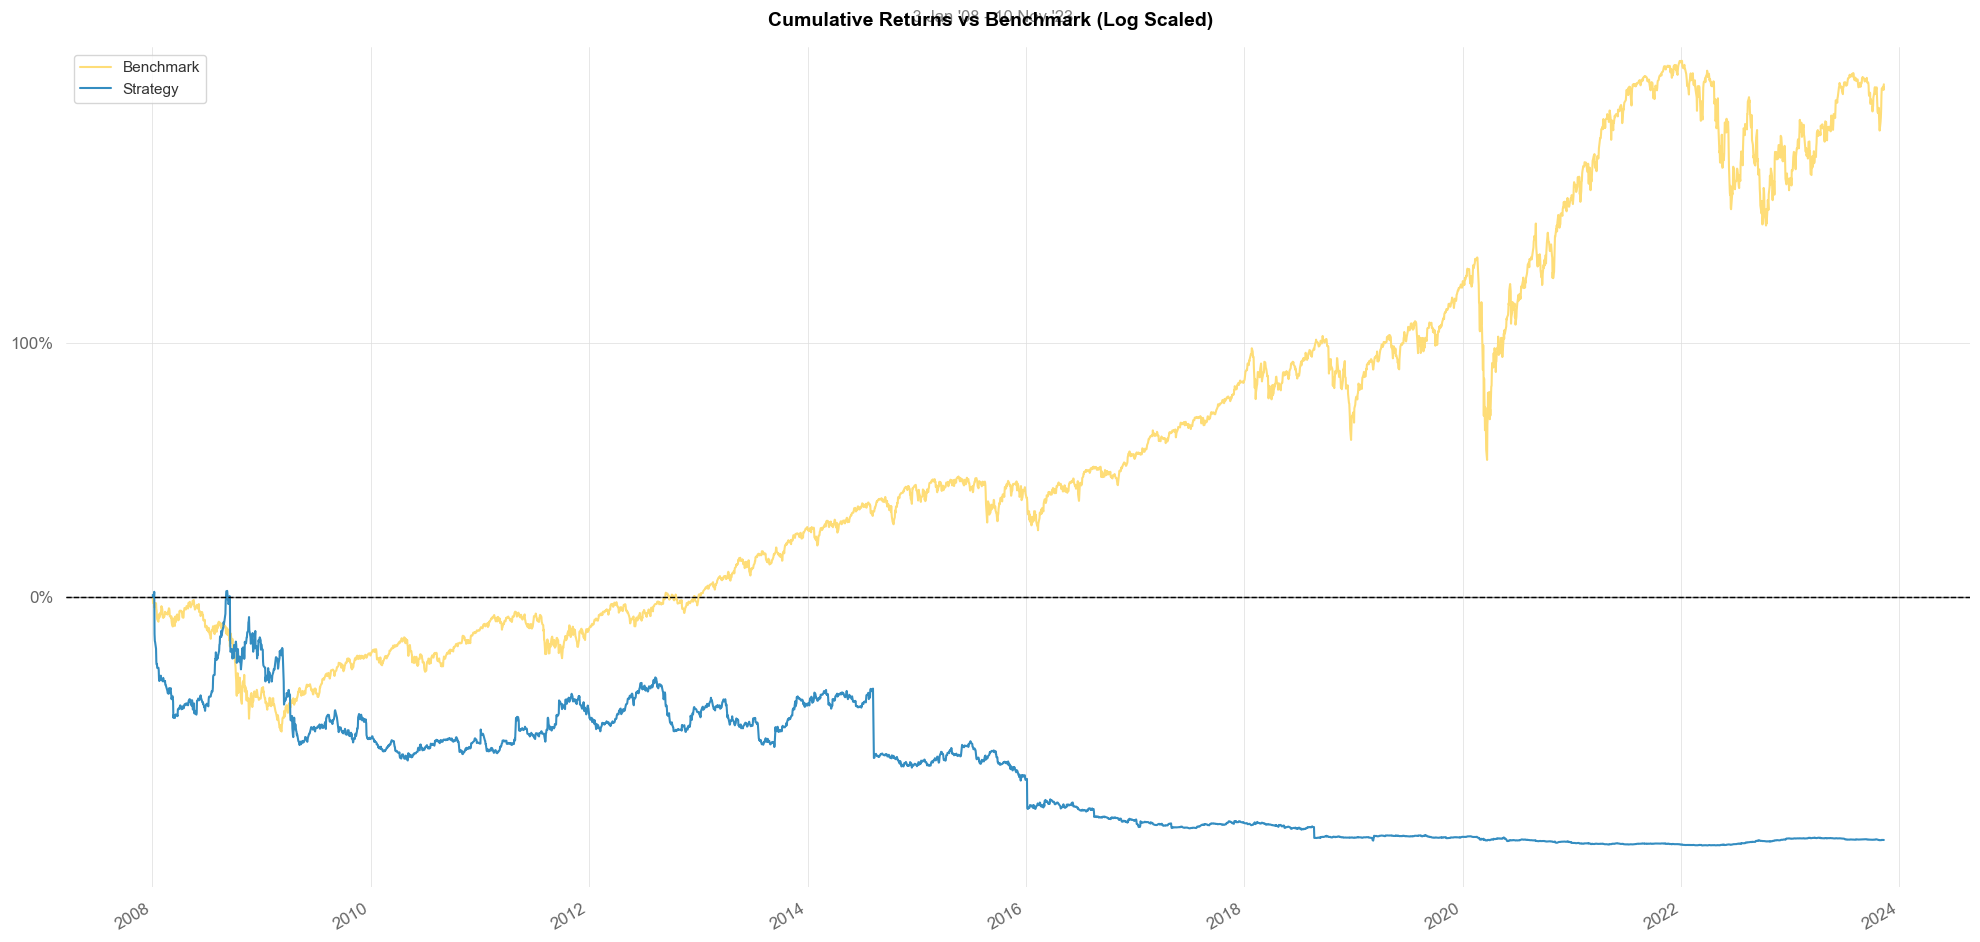

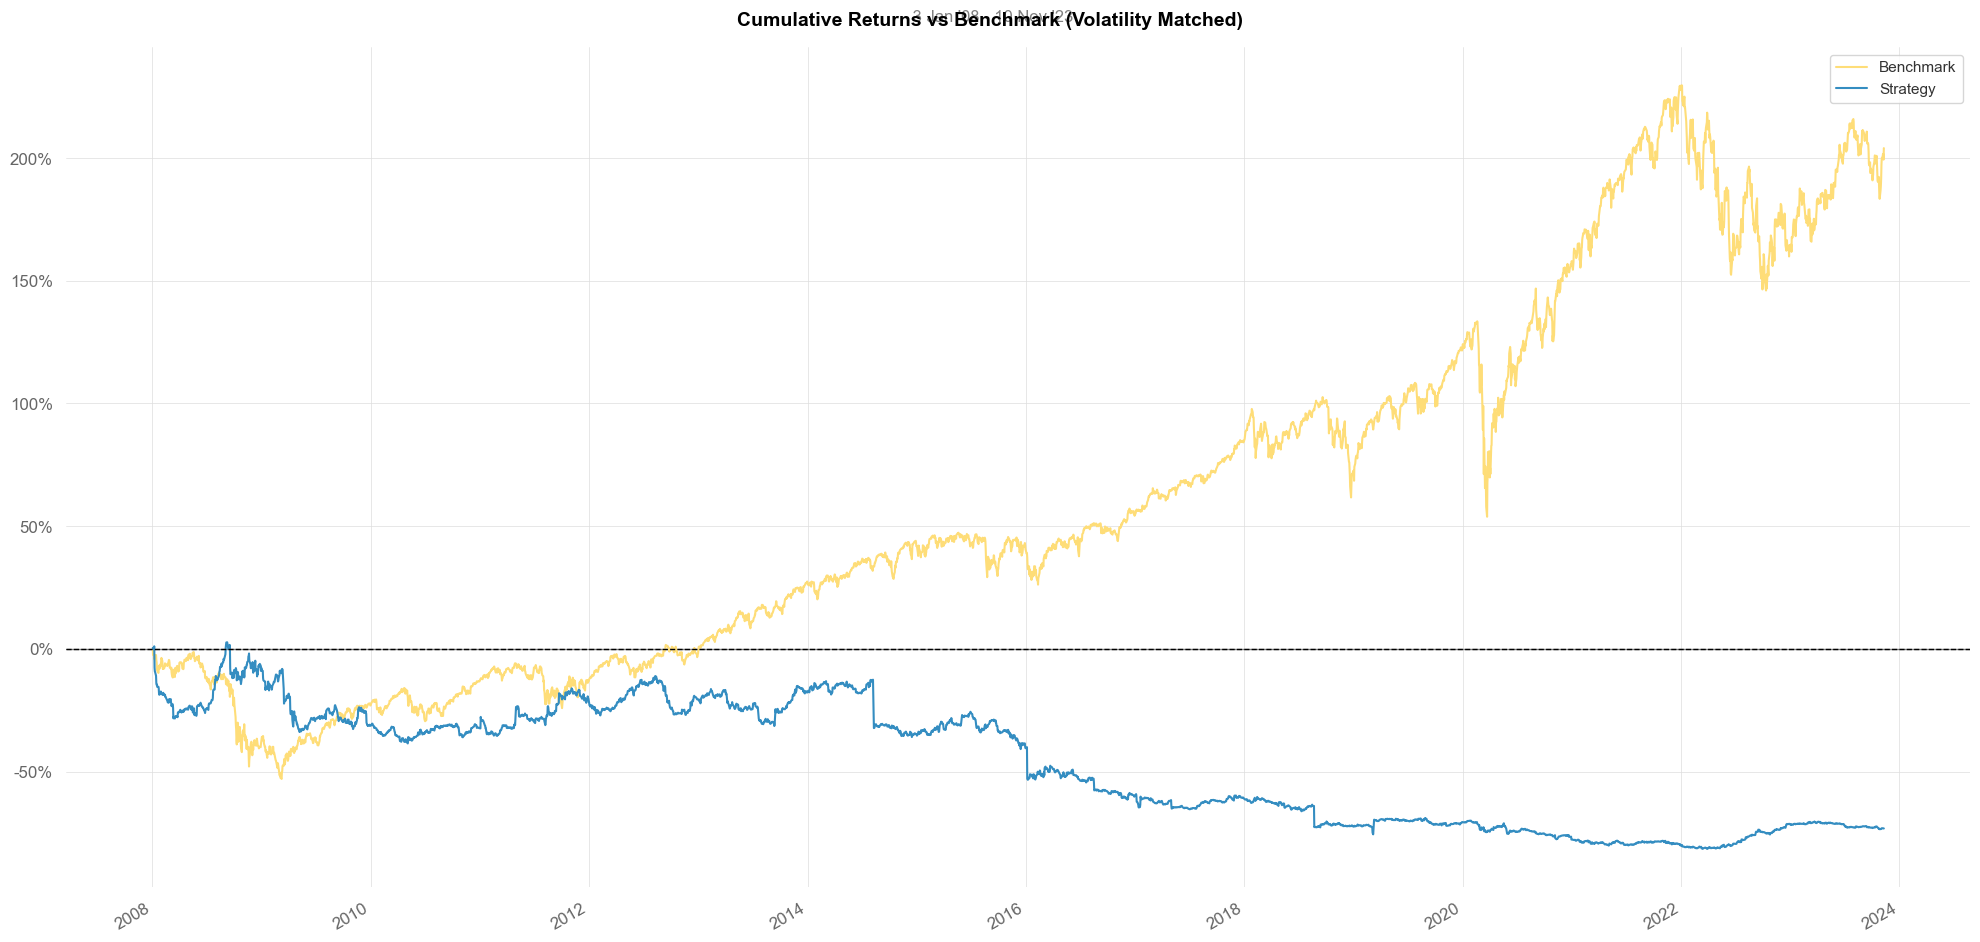

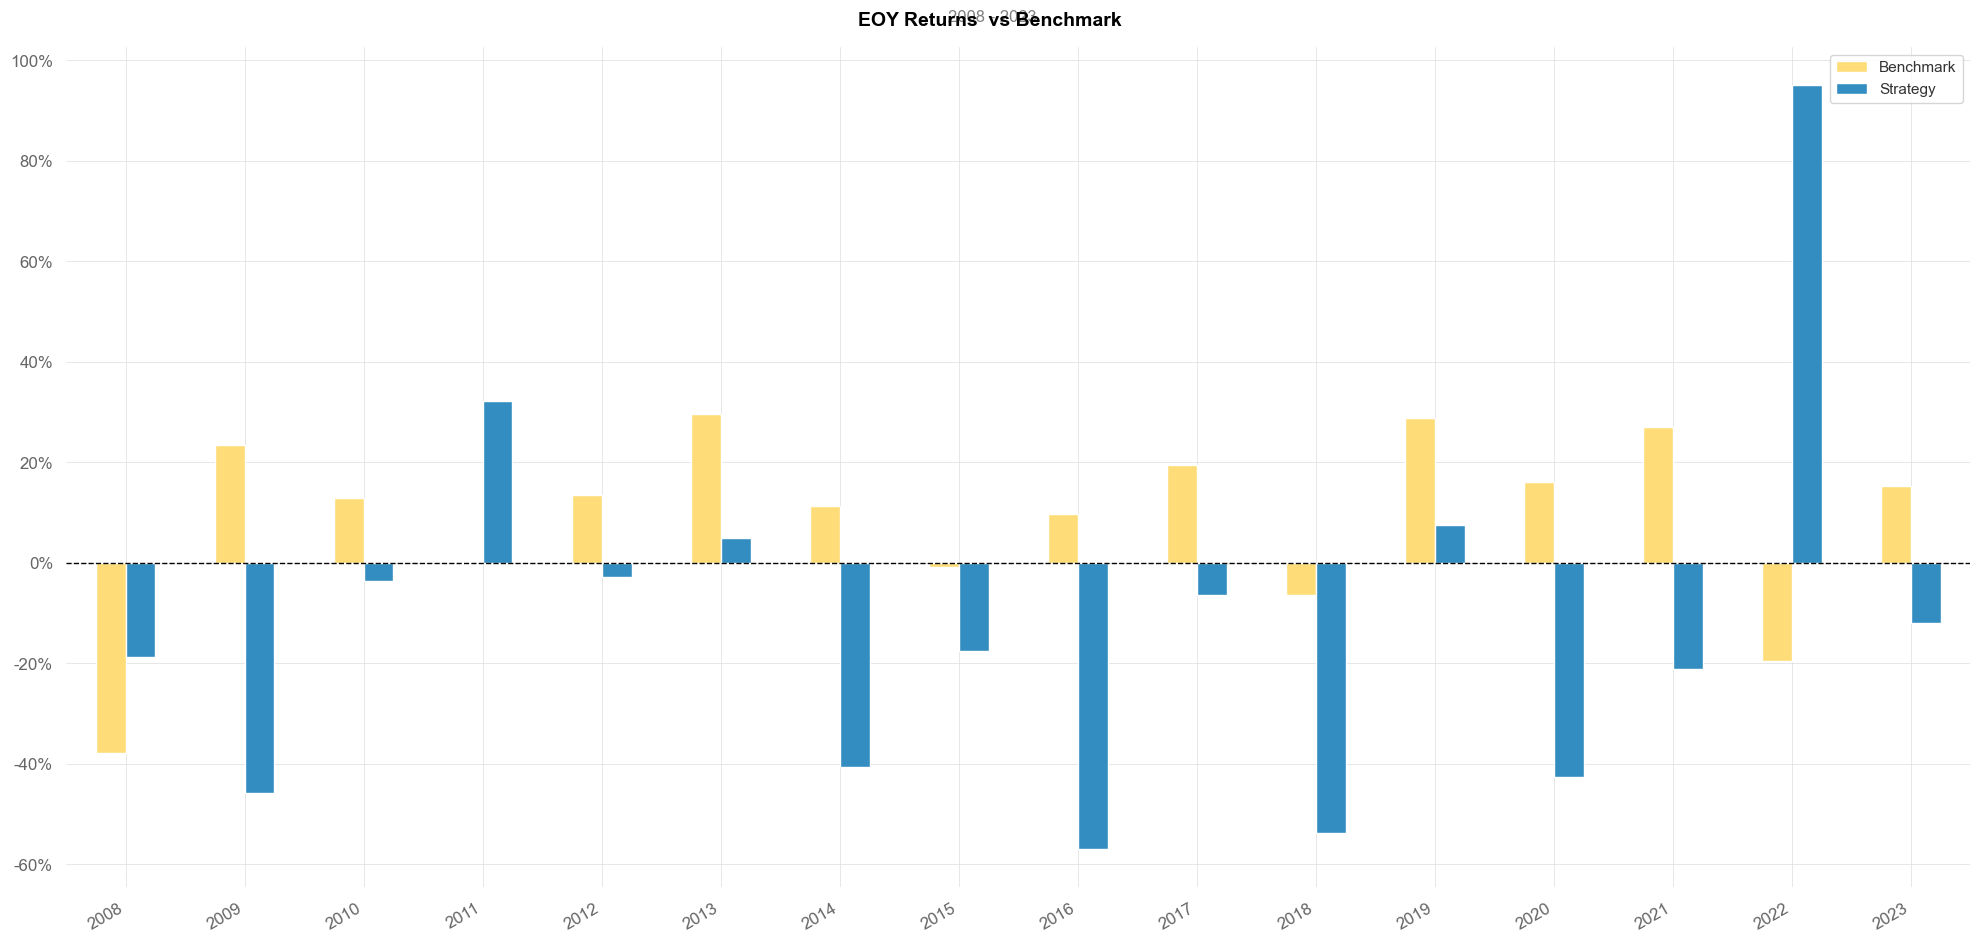

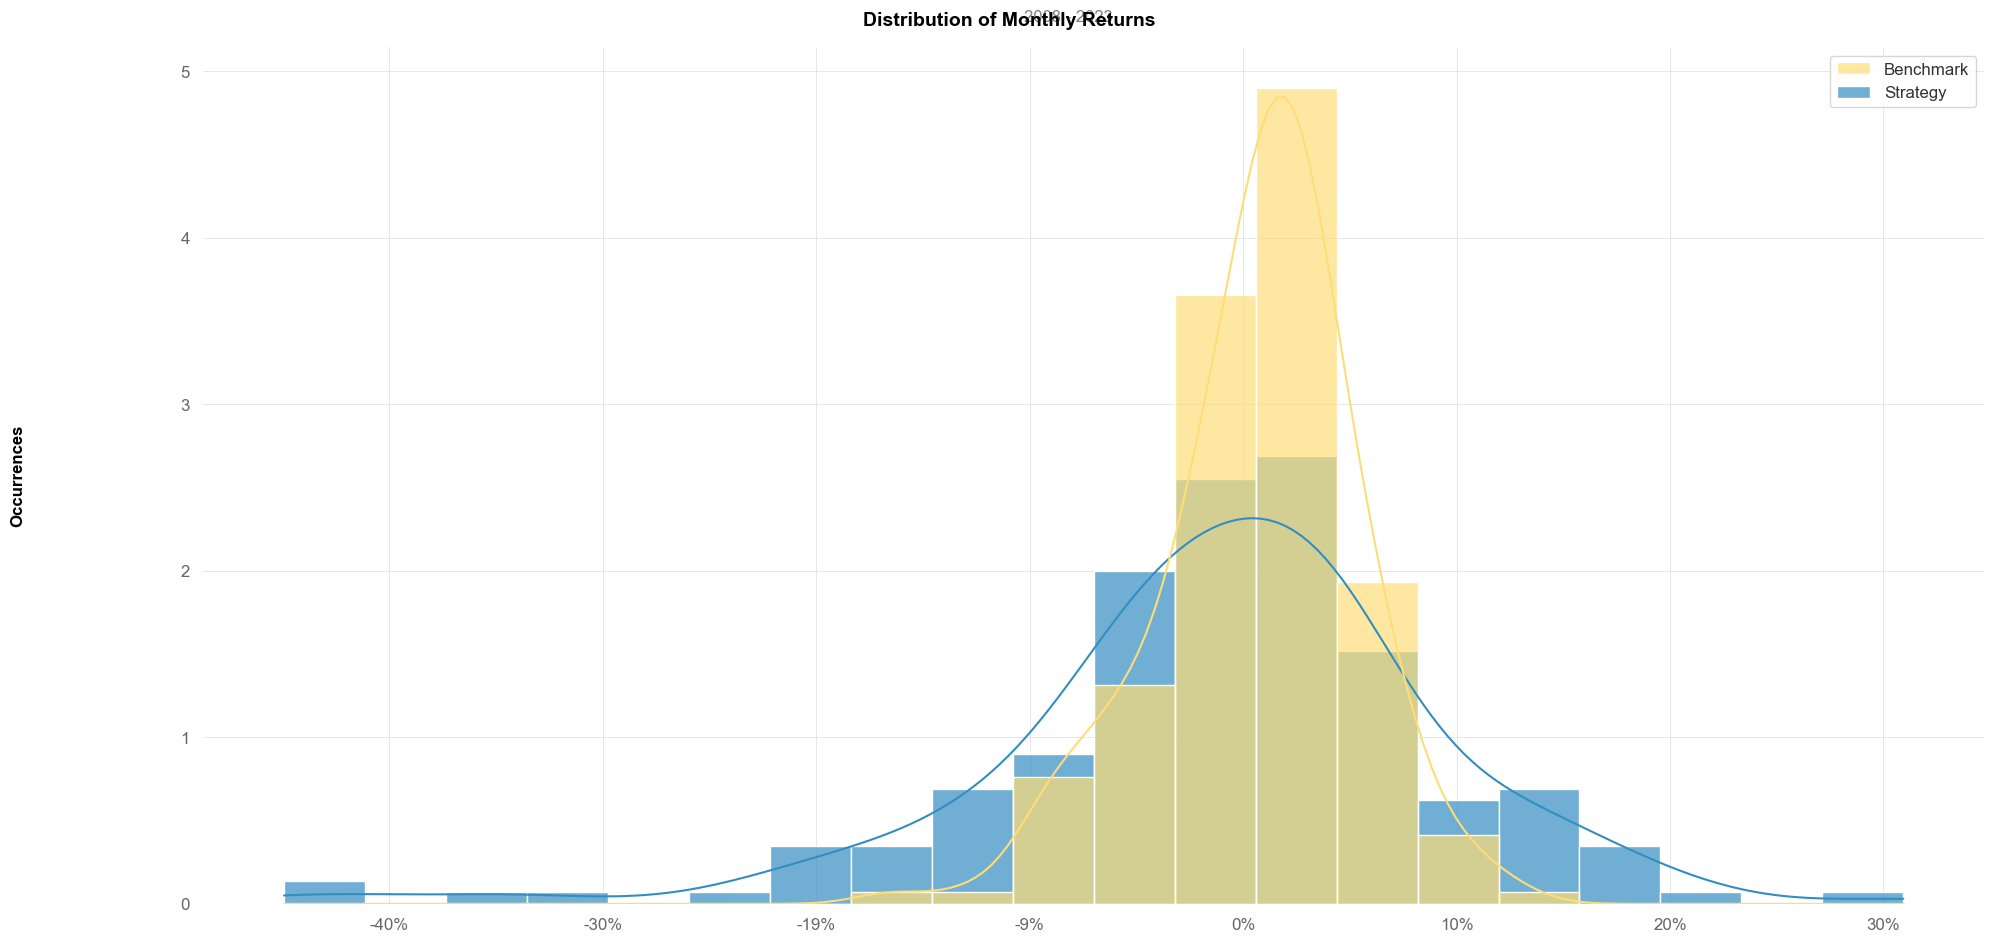

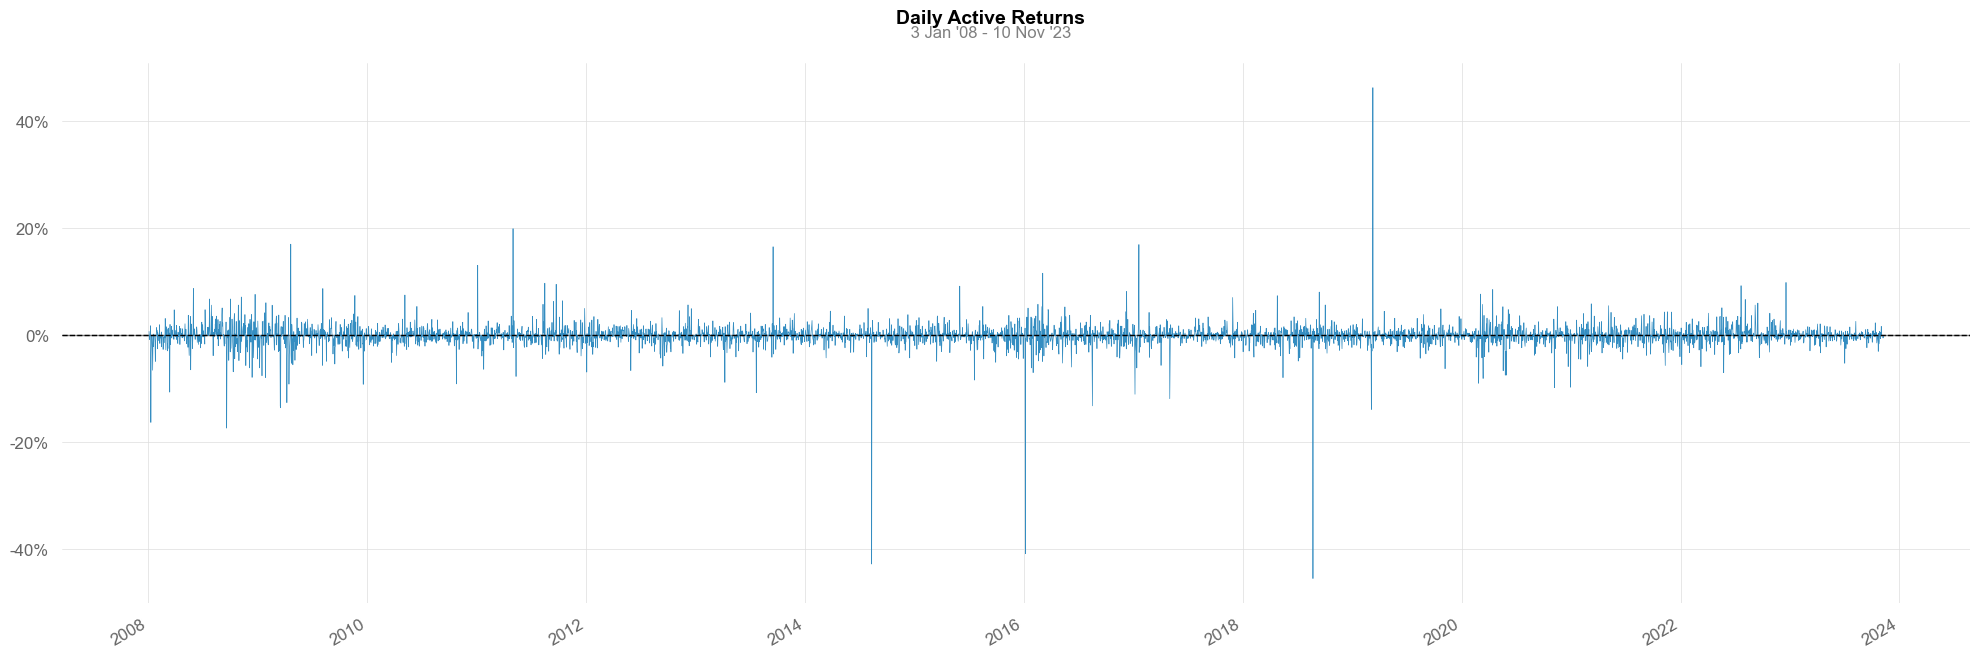

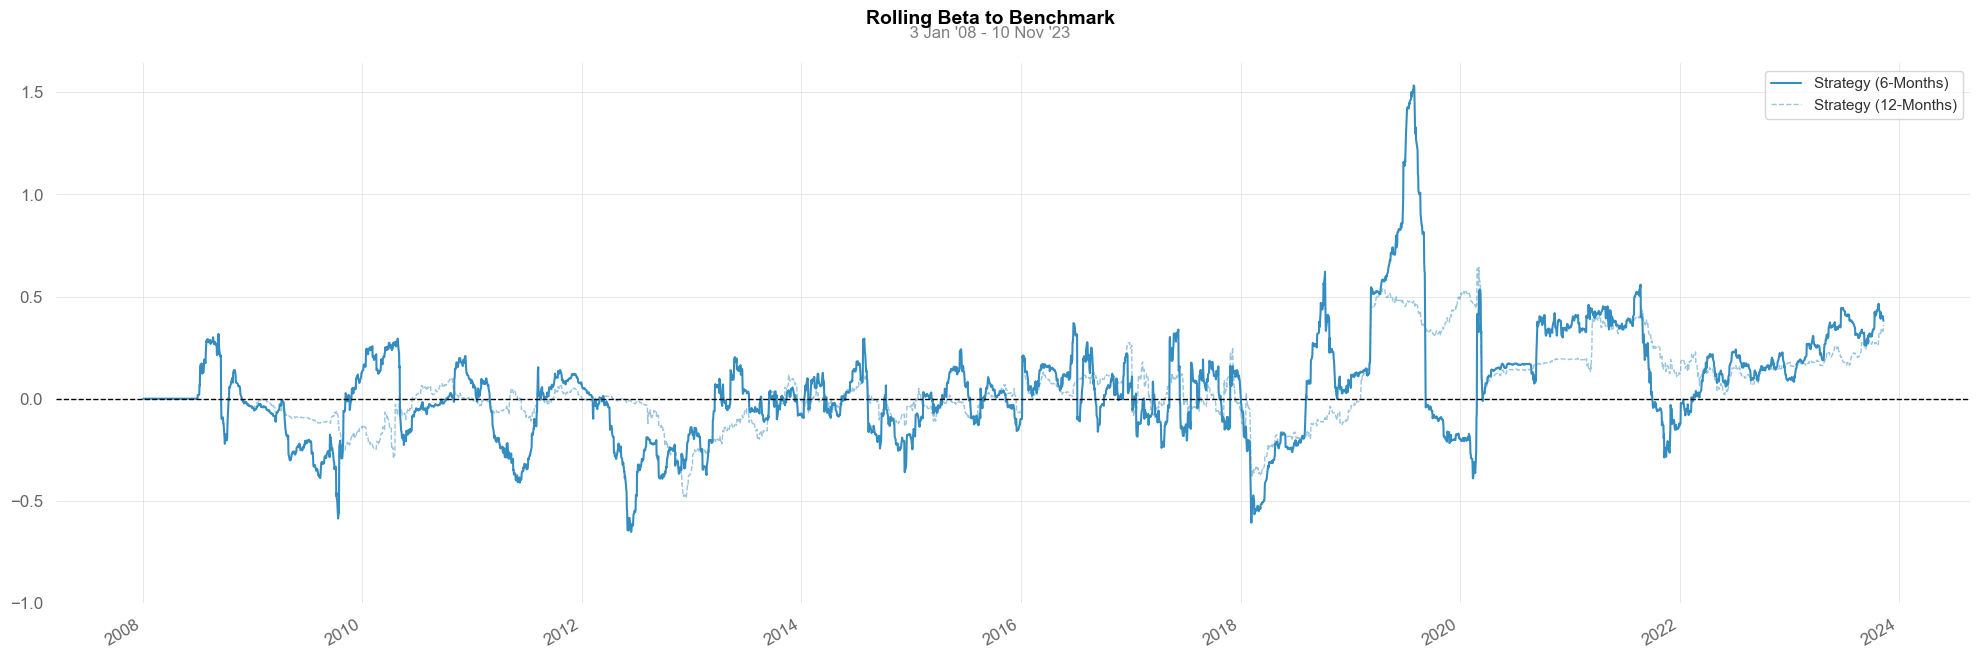

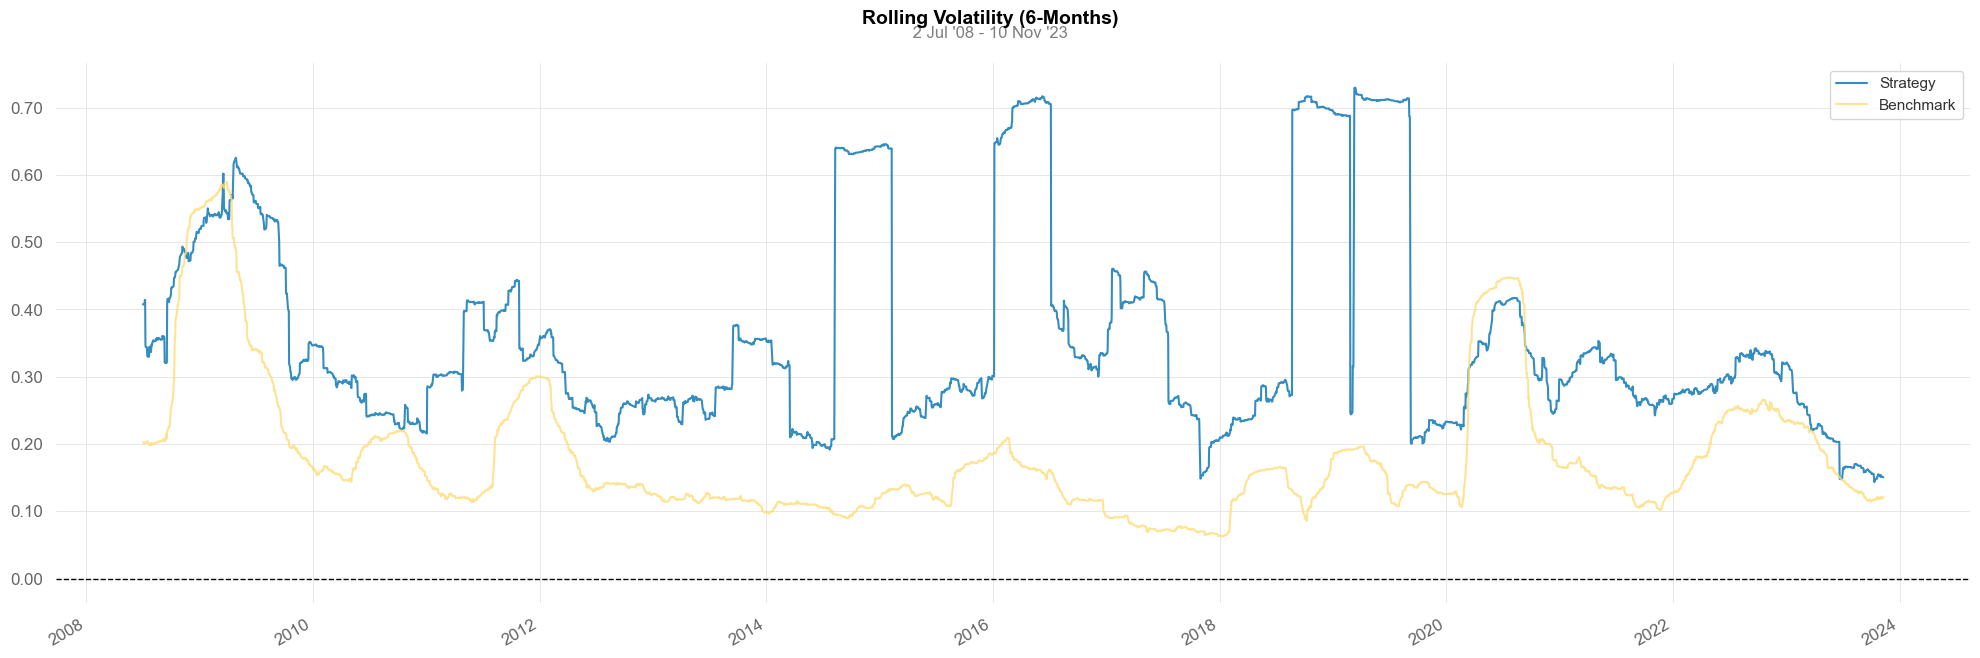

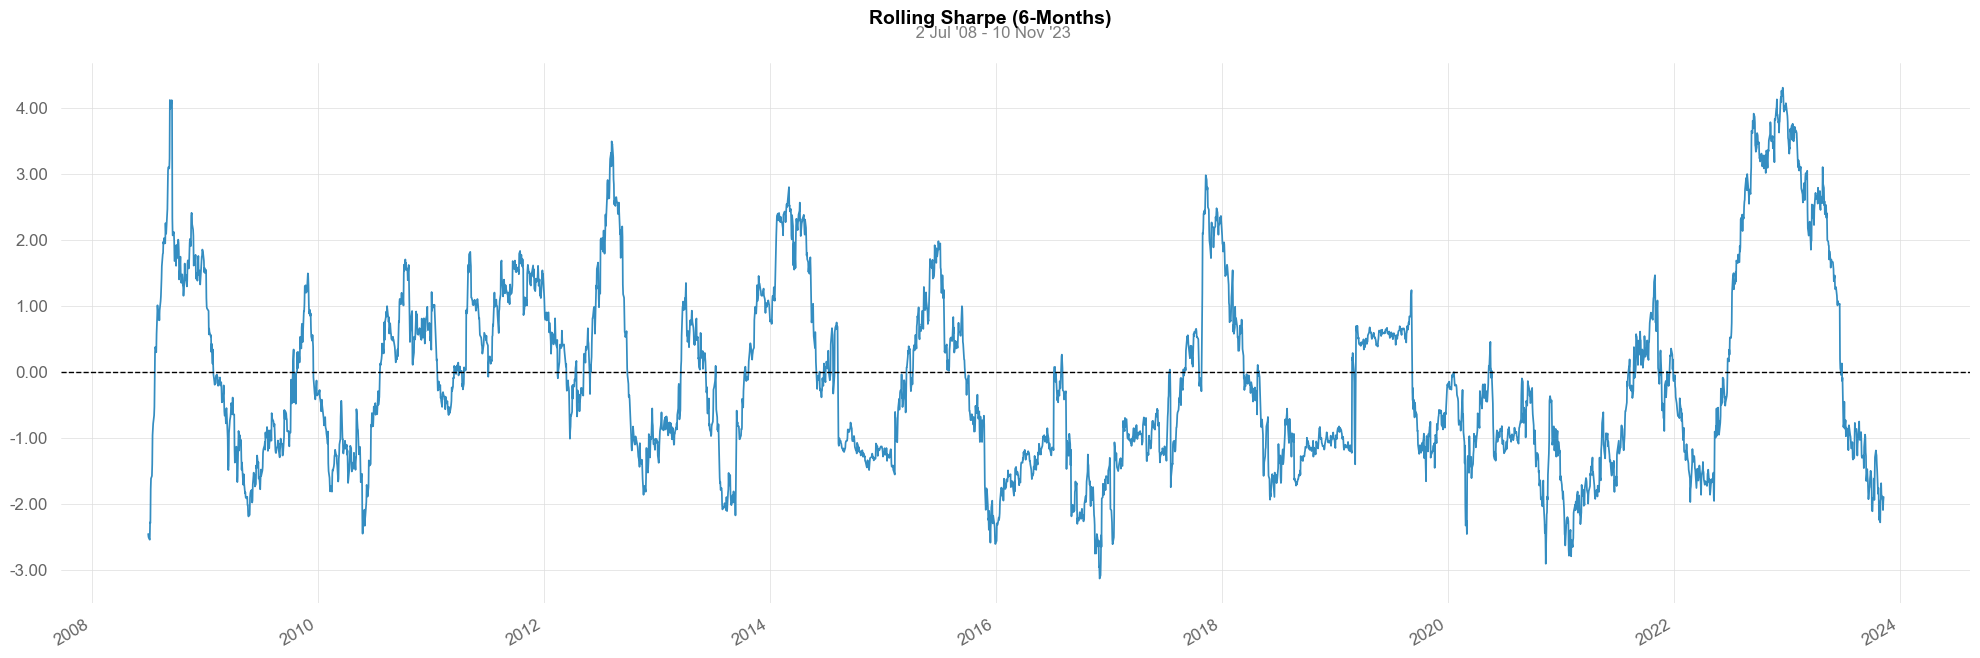

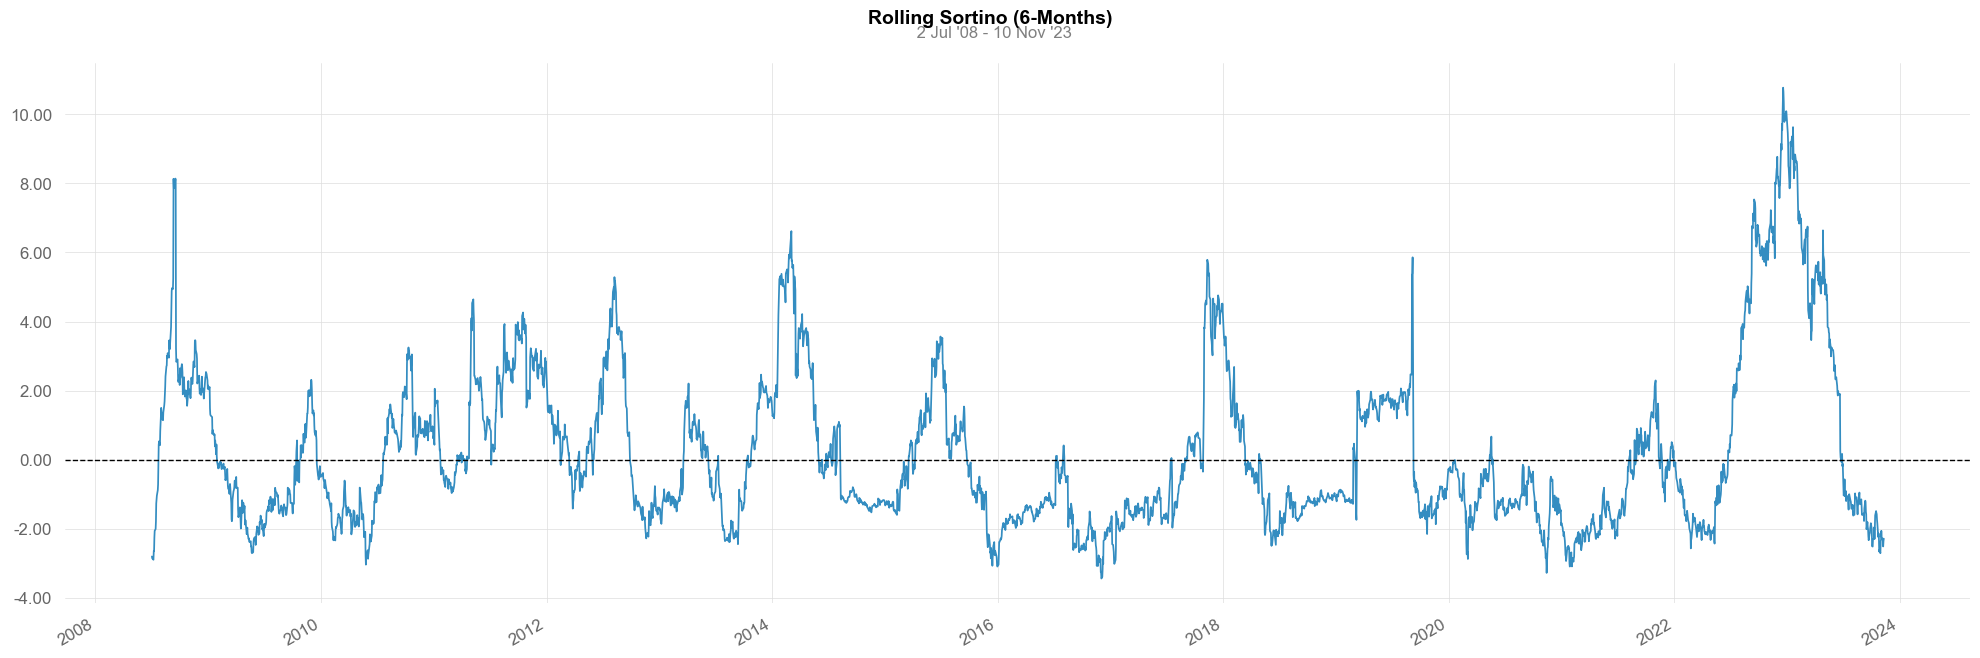

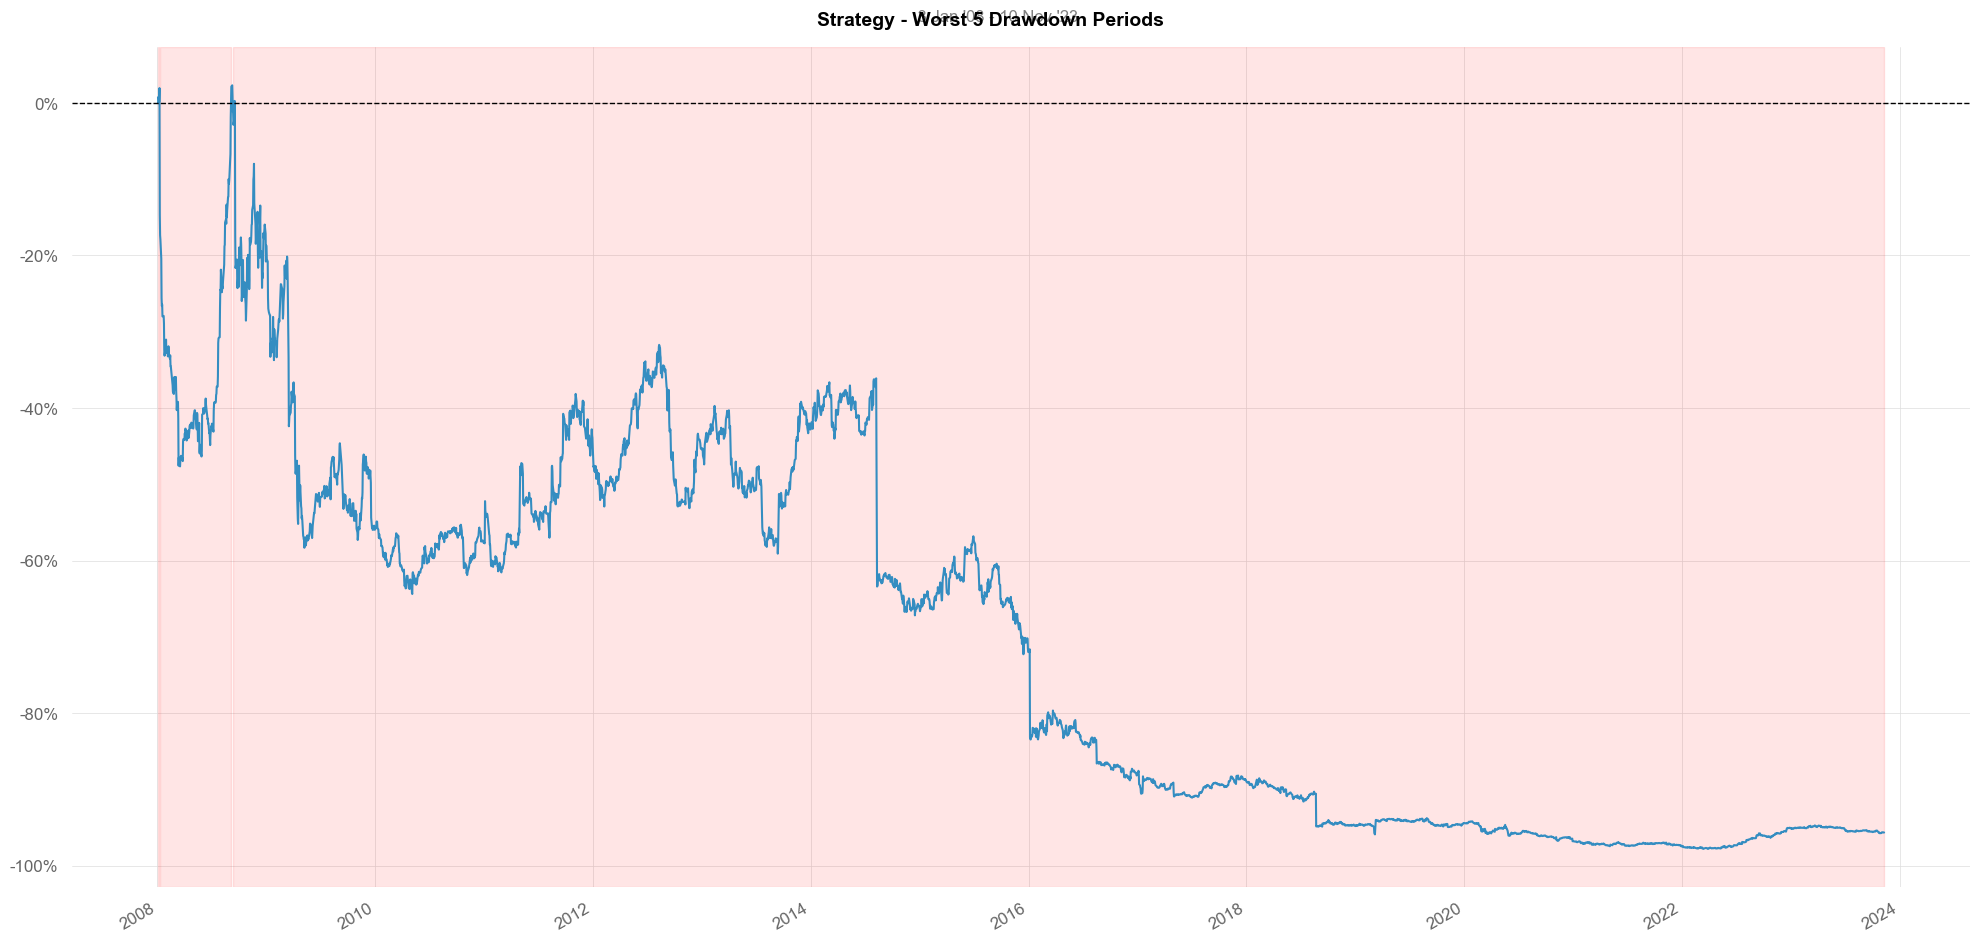

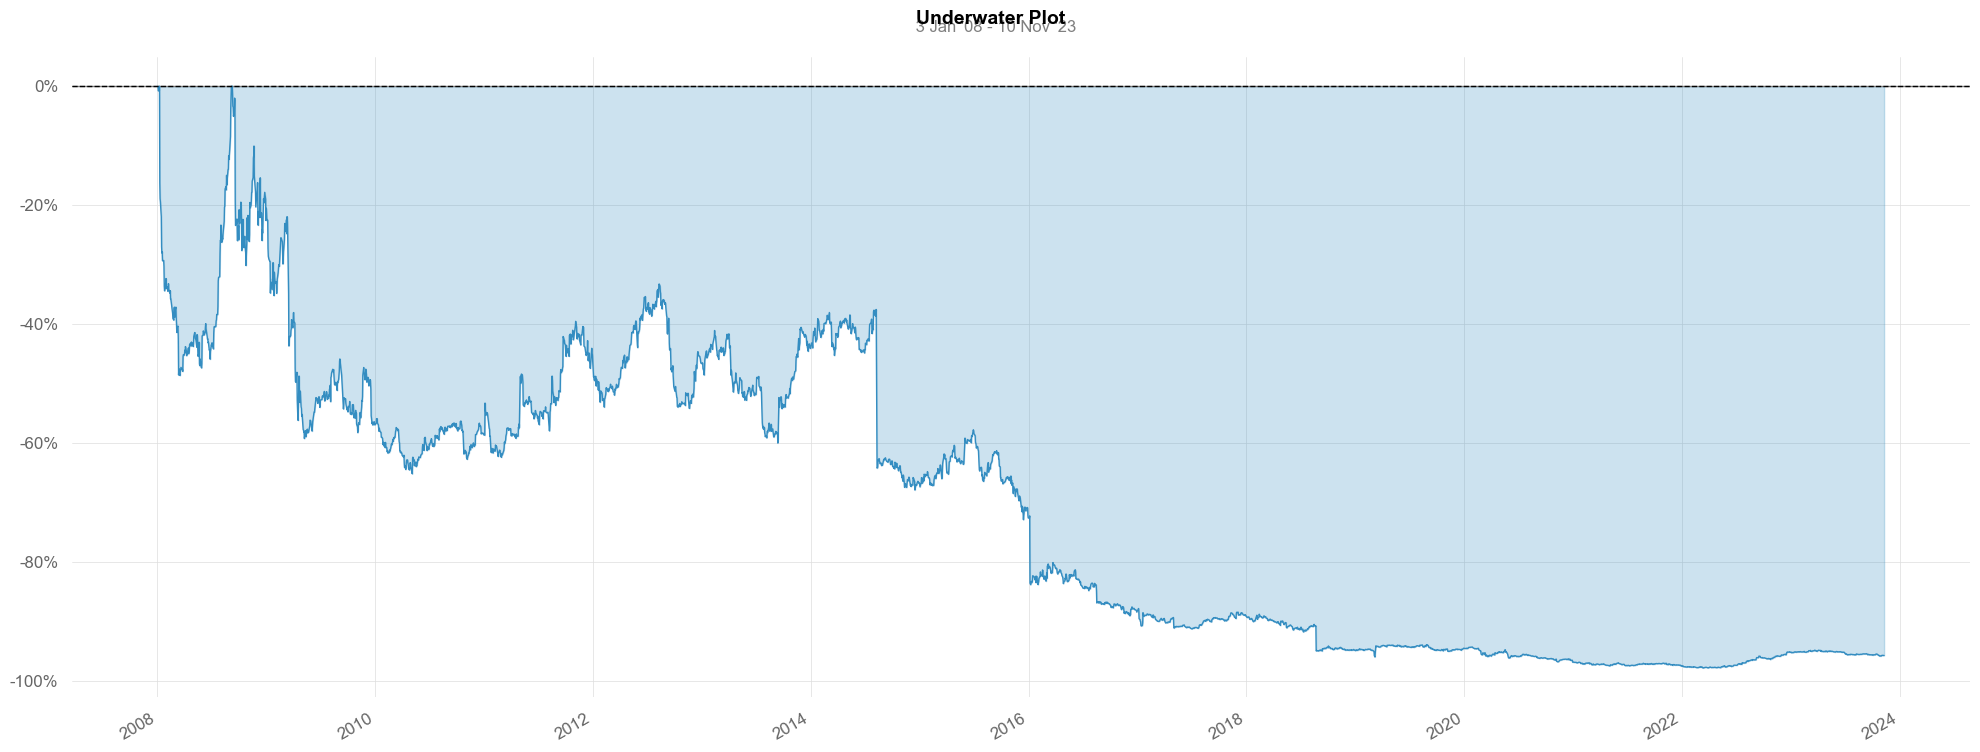

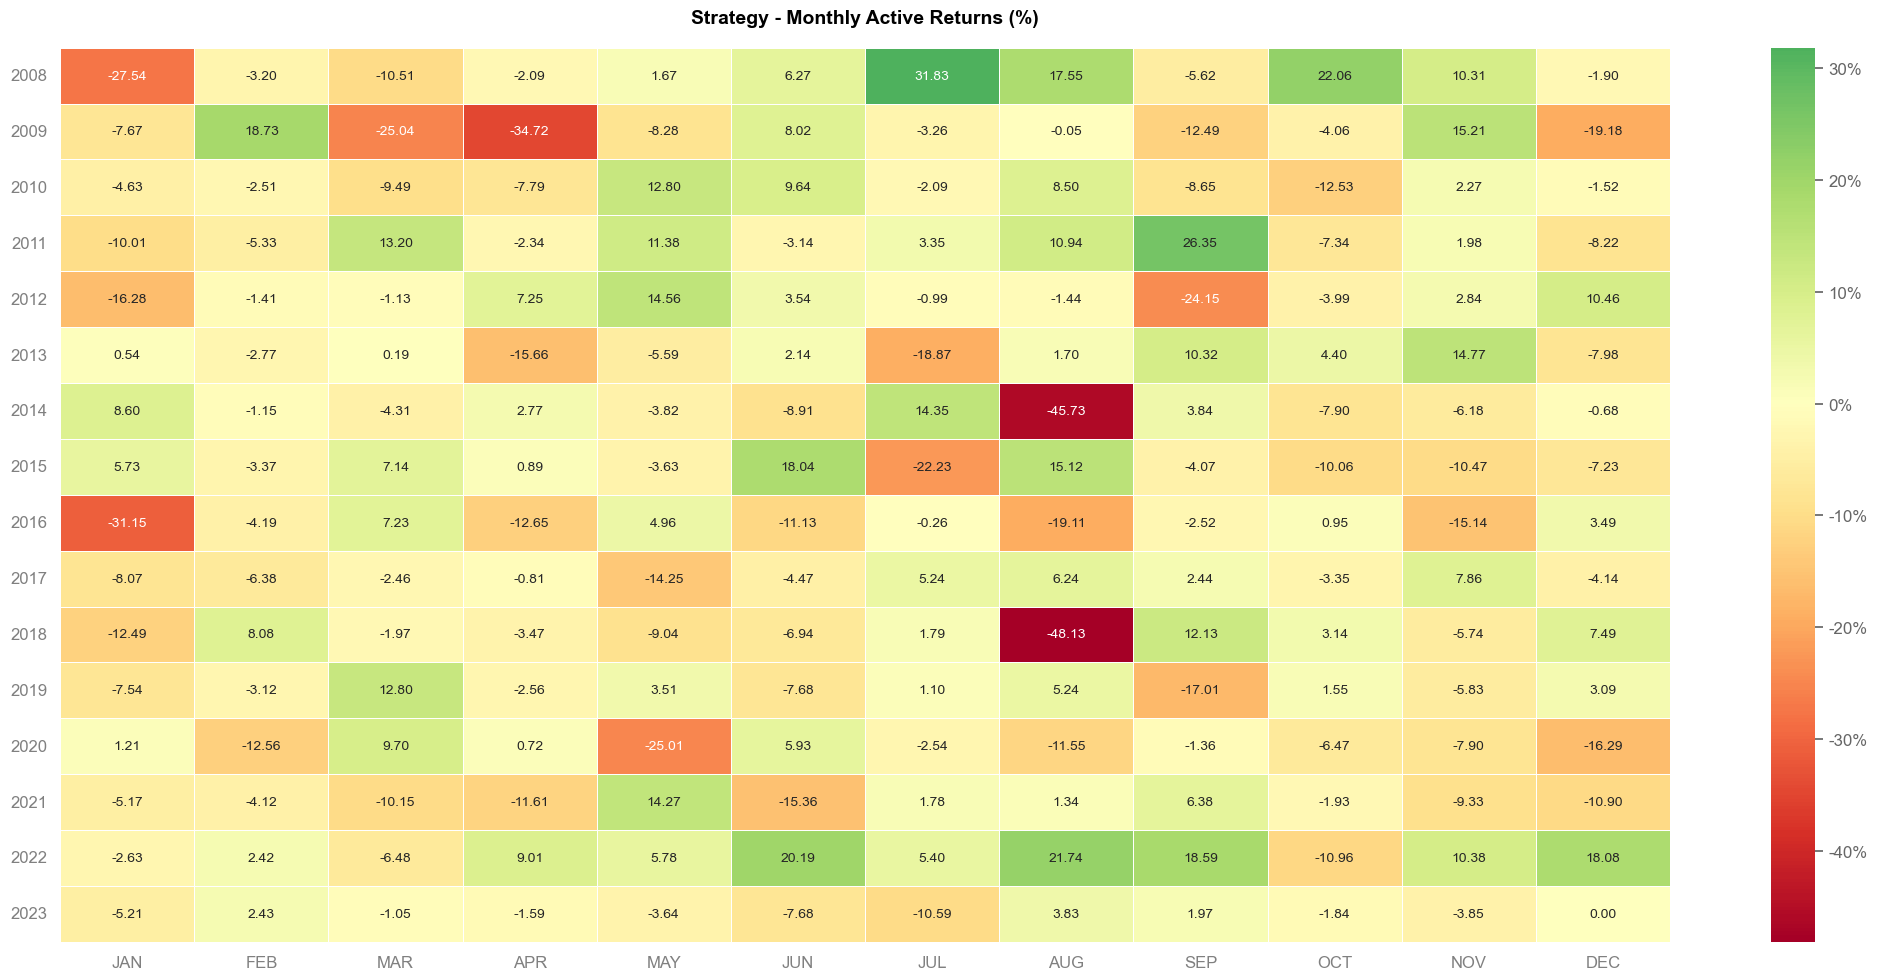

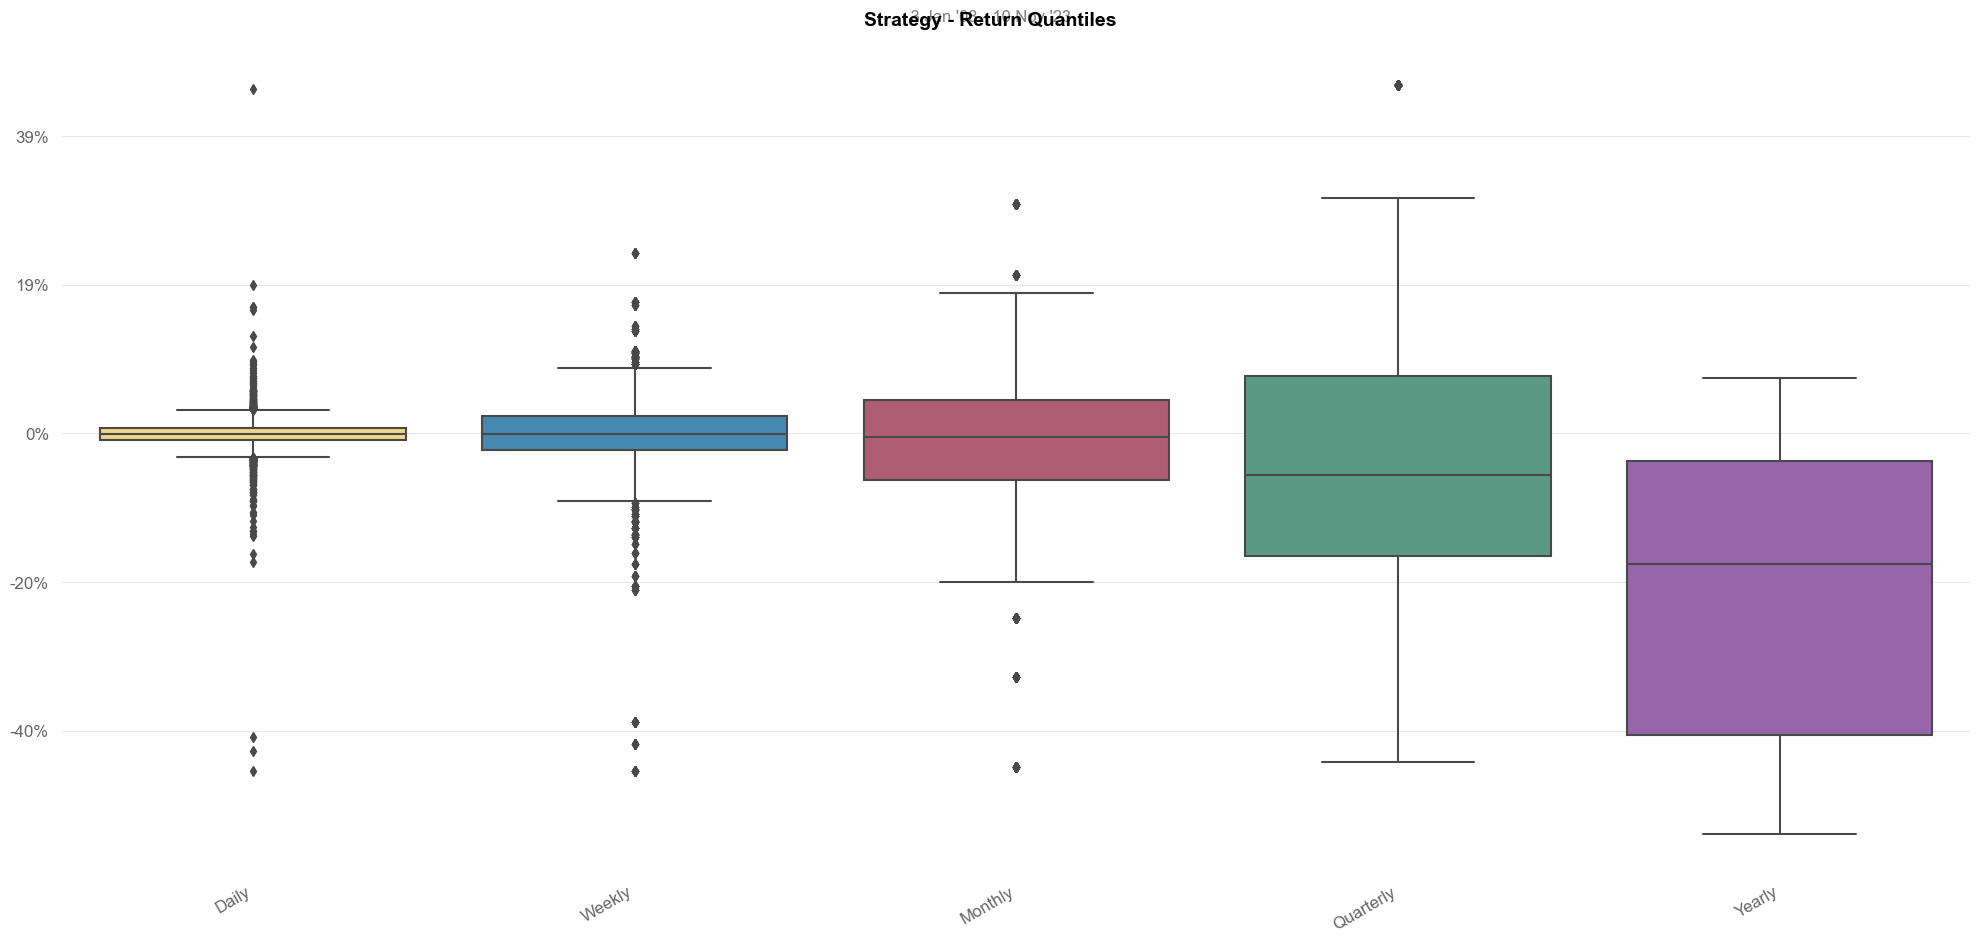

In [438]:
qs.reports.full(total_ret, 'SPY', figsize=(20, 10))